In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor_1
from models.graph_water_transformer_cov import graph_water_transformer_cov_gate_predictor_1
from losses.loss import gate_loss, gate_loss_1, gate_loss_2, water_level_threshold, water_level_threshold_1
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1

from tensorflow.keras.models import load_model
import matplotlib
from spektral.layers import GCNConv
import seaborn as sns

from tensorflow.keras import backend as KB
import random

random.seed(10)
print(random.random())

2023-08-15 10:40:20.210362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 10:40:23.387946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.5714025946899135


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Data processing

In [3]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor_1(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [5]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


In [6]:
input_shape = train_cov.shape[1:]

### Model

In [14]:
# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 36
lstm_units = 36
gate_min = 0.0
gate_max = 1.0

learning_rate = 3e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 700
BATCH = 512

### Gate predictor

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, atte_reg, l1_reg, l2_reg, dropout=0):
    """
    transformer encoder
    """
    # Normalization and Attention
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout, 
                                  kernel_regularizer=l2(atte_reg)
                                 )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x1 = layers.LayerNormalization(epsilon=1e-6)(res)
    #res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, 
                      kernel_size=2, 
                      activation="relu",
                      padding='same', 
                      kernel_regularizer=keras.regularizers.L1L2(l1=l1_reg, l2=l2_reg)
                     )(x1)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], 
                      kernel_size=2,
                      activation="relu",
                      padding='same', 
                      kernel_regularizer=keras.regularizers.L1L2(l1=l1_reg, l2=l2_reg)
                     )(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    return x + res

In [20]:
# ======================== covariates with transformer ========================
cov_inputs = keras.Input(shape=(input_shape), name='cov_inputs')

cov = layers.Masking(mask_value=1e-10)(cov_inputs)
for _ in range(num_transformer_blocks):
    cov = transformer_encoder(cov, head_size, num_heads, ff_dim, atte_reg, l1_reg, l2_reg, dropout) # (96,12)
#cov = layers.MaxPooling1D(pool_size=2, padding='same', name='pooling')(cov)
cov = cov[:, -72:, :]
cov_reshape = layers.Reshape((12, 72), name='cov_reshape')(cov)


# ======================== water levels with GNN ========================
inp_lap = Input((5, 5), name='inp_lap')
inp_seq = Input((5, 72), name='inp_seq')

# GCN
x = GCNConv(gcn_unit1, activation='relu', name='GCNConv1')([inp_seq, inp_lap])
x = GCNConv(gcn_unit2, activation='relu', name='GCNConv2')([x, inp_lap]) # (5, 36)


# RNN
xx = layers.LSTM(lstm_units, activation='relu', return_sequences=True, name='LSTM')(inp_seq) # (5, 36)

# ws = x + xx  # (5, 72)
ws = layers.Concatenate(name='concate_ws', axis=-1)([x, xx])

# ======================== CONCAT and Attention ========================
x = layers.Concatenate(name='concate', axis=1)([cov_reshape, ws])
x, atte_scores = layers.Attention(name='attention')([x, x], return_attention_scores=True)


# ======================== final output ========================
x = layers.Flatten()(x)
x = layers.Dense(24*16, activation='relu')(x)
x = layers.Reshape((24, 16))(x)
#x = Dense(7, activation=bounded_activation(gate_min, gate_max))(x)
x = layers.Dense(7)(x)
out = KB.minimum(KB.maximum(x, gate_min), gate_max)

gate_predictor = Model(inputs=[cov_inputs, inp_seq, inp_lap], outputs=out, name='gate_predictor_model')
gate_predictor.summary()

Model: "gate_predictor_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cov_inputs (InputLayer)     [(None, 96, 12)]             0         []                            
                                                                                                  
 masking_7 (Masking)         (None, 96, 12)               0         ['cov_inputs[0][0]']          
                                                                                                  
 multi_head_attention_7 (Mu  (None, 96, 12)               29388     ['masking_7[0][0]',           
 ltiHeadAttention)                                                   'masking_7[0][0]']           
                                                                                                  
 dropout_14 (Dropout)        (None, 96, 12)               0         ['multi_hea

### water stage predictor

In [21]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

### Combine gate_predictor and trained ws_predictor

In [22]:
inputs_cov = Input(shape=(96, 12), name='input_cov')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor([inputs_cov, inputs_tws, inputs_adj])  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_cov[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_cov[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs_cov = layers.Concatenate(axis=1)([inputs_cov[:, :n_hours, :], replaced_future_gate_pump])

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_cov, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
filda.summary()

Model: "filda"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_cov (InputLayer)      [(None, 96, 12)]             0         []                            
                                                                                                  
 input_tws (InputLayer)      [(None, 5, 72)]              0         []                            
                                                                                                  
 input_adj (InputLayer)      [(None, 5, 5)]               0         []                            
                                                                                                  
 gate_predictor_model (Func  (None, 24, 7)                523891    ['input_cov[0][0]',           
 tional)                                                             'input_tws[0][0]',       

In [23]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 2.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/gtnp_gtnp_explainability1.h5'.format(n_hours, K),
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_cov, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_cov, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,
                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

Epoch 1/700


2023-08-15 10:52:13.415790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-15 10:52:14.651883: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7eb4b6e770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 10:52:14.651950: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-15 10:52:14.660728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-15 10:52:15.014879: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_ws_predictor_loss improved from inf to 2.63417, saving model to ../saved_models/gtnp_gtnp_explainability1.h5
151/151 - 28s - loss: 0.4887 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.2316 - val_loss: 5.2720 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 2.6342 - 28s/epoch - 187ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss improved from 2.63417 to 2.53794, saving model to ../saved_models/gtnp_gtnp_explainability1.h5
151/151 - 13s - loss: 0.4523 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.2245 - val_loss: 5.0789 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 2.5379 - 13s/epoch - 84ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss improved from 2.53794 to 2.37189, saving model to ../saved_models/gtnp_gtnp_explainability1.h5
151/151 - 13s - loss: 0.4396 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.2184 - val_loss: 4.7465 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 2.3719 - 13s/epoch - 85ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss improved from 2.37189 to 2.16968, saving model to ../saved_models/gtnp_gtnp_explainability1.h5
151/151 - 13s - loss: 0.4314 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.2146 - val_loss: 4.3415 - val_gate_predictor_model_loss: 0.0000e+00 - v

Epoch 27/700

Epoch 27: val_ws_predictor_loss did not improve from 1.69911
151/151 - 13s - loss: 0.3856 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1925 - val_loss: 3.4089 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7041 - 13s/epoch - 84ms/step
Epoch 28/700

Epoch 28: val_ws_predictor_loss did not improve from 1.69911
151/151 - 13s - loss: 0.3855 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1924 - val_loss: 3.4096 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7045 - 13s/epoch - 84ms/step
Epoch 29/700

Epoch 29: val_ws_predictor_loss improved from 1.69911 to 1.67613, saving model to ../saved_models/gtnp_gtnp_explainability1.h5
151/151 - 13s - loss: 0.3848 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1921 - val_loss: 3.3529 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6761 - 13s/epoch - 84ms/step
Epoch 30/700

Epoch 30: val_ws_predictor_loss did not improve


Epoch 54: val_ws_predictor_loss did not improve from 1.64232
151/151 - 13s - loss: 0.3831 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1913 - val_loss: 3.2859 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6427 - 13s/epoch - 84ms/step
Epoch 55/700

Epoch 55: val_ws_predictor_loss did not improve from 1.64232
151/151 - 13s - loss: 0.3830 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1913 - val_loss: 3.3060 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6528 - 13s/epoch - 84ms/step
Epoch 56/700

Epoch 56: val_ws_predictor_loss did not improve from 1.64232
151/151 - 13s - loss: 0.3829 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1912 - val_loss: 3.2936 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6466 - 13s/epoch - 84ms/step
Epoch 57/700

Epoch 57: val_ws_predictor_loss did not improve from 1.64232
151/151 - 13s - loss: 0.3903 - gate_predictor_model_loss: 0.0000e

151/151 - 13s - loss: 0.3813 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1905 - val_loss: 3.2570 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6283 - 13s/epoch - 84ms/step
Epoch 82/700

Epoch 82: val_ws_predictor_loss did not improve from 1.60971
151/151 - 13s - loss: 0.3812 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1905 - val_loss: 3.2421 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6209 - 13s/epoch - 84ms/step
Epoch 83/700

Epoch 83: val_ws_predictor_loss improved from 1.60971 to 1.60746, saving model to ../saved_models/gtnp_gtnp_explainability1.h5
151/151 - 13s - loss: 0.3813 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1905 - val_loss: 3.2153 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6075 - 13s/epoch - 85ms/step
Epoch 84/700

Epoch 84: val_ws_predictor_loss did not improve from 1.60746
151/151 - 13s - loss: 0.3812 - gate_predictor_model_loss: 0.0

Epoch 109/700

Epoch 109: val_ws_predictor_loss did not improve from 1.60115
151/151 - 13s - loss: 0.3813 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1904 - val_loss: 3.2057 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6026 - 13s/epoch - 83ms/step
Epoch 110/700

Epoch 110: val_ws_predictor_loss improved from 1.60115 to 1.59565, saving model to ../saved_models/gtnp_gtnp_explainability1.h5
151/151 - 13s - loss: 0.3811 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1904 - val_loss: 3.1917 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5957 - 13s/epoch - 84ms/step
Epoch 111/700

Epoch 111: val_ws_predictor_loss did not improve from 1.59565
151/151 - 13s - loss: 0.3811 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1904 - val_loss: 3.2123 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6060 - 13s/epoch - 84ms/step
Epoch 112/700

Epoch 112: val_ws_predictor_loss did not

Epoch 137/700

Epoch 137: val_ws_predictor_loss did not improve from 1.59565
151/151 - 13s - loss: 0.3815 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1906 - val_loss: 3.3010 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6503 - 13s/epoch - 83ms/step
Epoch 138/700

Epoch 138: val_ws_predictor_loss did not improve from 1.59565
151/151 - 13s - loss: 0.3809 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1903 - val_loss: 3.2489 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6243 - 13s/epoch - 83ms/step
Epoch 139/700

Epoch 139: val_ws_predictor_loss did not improve from 1.59565
151/151 - 13s - loss: 0.3807 - gate_predictor_model_loss: 0.0000e+00 - ws_predictor_loss: 0.1902 - val_loss: 3.2373 - val_gate_predictor_model_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6185 - 13s/epoch - 83ms/step
Epoch 140/700

Epoch 140: val_ws_predictor_loss did not improve from 1.59565
151/151 - 13s - loss: 0.3807 - gate_predicto

KeyboardInterrupt: 

In [24]:
saved_model = load_model('../saved_models/gtnp_gtnp_explainability1.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [25]:
demo = 7635
test_X_demo = test_X_mask[demo:demo+1, :, :]  # (1, 96, 16)
test_cov_demo = test_cov[demo:demo+1, :, :]
test_tws_demo = test_tws_reshape[demo:demo+1, :, :]
test_adj_mat_demo = test_adj_mat[demo:demo+1, :, :]

In [26]:
test_X_demo_inv = scaler.inverse_transform(test_X_demo.reshape((1, 96*16)))
test_X_demo_inv = test_X_demo_inv.reshape((96, 16))
test_X_demo_inv.shape  # (96, 16) with inverse

(96, 16)

In [27]:
# INPUTS = ['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
#         'HWS_S25A', 'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

# plt.rcParams["figure.figsize"] = (9, 18)
# fig = plt.figure(tight_layout=True)
# gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)

# for i in range(len(INPUTS)):
# #     if i == 7 or 8 or 9:
# #         continue
#     ax = fig.add_subplot(gs[i, :])
#     ax.plot(test_X_demo_inv[:, i], linewidth=1.5)
#     ax.set_title('{}'.format(INPUTS[i]), fontsize=12)
#     plt.xticks(np.arange(0, 96, 4))
    
# plt.show()

In [28]:
gate_pump_pred, ws_pred = saved_model.predict([test_cov_demo, test_tws_demo, test_adj_mat_demo])


gate_pump_pred = gate_pump_pred.reshape((-1, 24*7))
gate_pump_pred_inv = gate_scalar.inverse_transform(gate_pump_pred)
gate_pump_pred_inv = gate_pump_pred_inv.reshape((-1, 24, 7))

print(gate_pump_pred_inv.shape)
print(ws_pred.shape)

1/1 [==============================] - 1s 851ms/step
(1, 24, 7)
(1, 96)


In [29]:
gate_predictor_trained = saved_model.get_layer('gate_predictor_model')
gate_predictor_trained.summary()

Model: "gate_predictor_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cov_inputs (InputLayer)     [(None, 96, 12)]             0         []                            
                                                                                                  
 masking_7 (Masking)         (None, 96, 12)               0         ['cov_inputs[0][0]']          
                                                                                                  
 multi_head_attention_7 (Mu  (None, 96, 12)               29388     ['masking_7[0][0]',           
 ltiHeadAttention)                                                   'masking_7[0][0]']           
                                                                                                  
 dropout_14 (Dropout)        (None, 96, 12)               0         ['multi_hea

### Attention among stations

In [30]:
atte_model = Model(inputs=gate_predictor_trained.input, 
                   outputs=[gate_predictor_trained.output, 
                            gate_predictor_trained.get_layer('attention').output
                           ]
                        )

In [31]:
gate_pred_demo, (atte_opt_demo, atte_score_demo) = atte_model.predict([test_cov_demo, test_tws_demo, test_adj_mat_demo])

1/1 [==============================] - 0s 422ms/step


In [32]:
print(gate_pred_demo.shape, atte_opt_demo.shape, atte_score_demo.shape)

(1, 24, 7) (1, 17, 72) (1, 17, 17)


In [34]:
atte_score_demo = atte_score_demo.reshape((17, 17))
atte_score_demo.shape

(17, 17)

In [35]:
atte_score_demo

array([[4.29952413e-01, 9.43612122e-06, 2.23274097e-01, 1.36462959e-05,
        9.25105214e-02, 1.47971014e-05, 6.21786751e-02, 8.83645225e-06,
        5.37555628e-02, 4.31985222e-02, 5.29603772e-02, 4.16393392e-02,
        8.49936332e-05, 1.24552462e-04, 1.18630240e-04, 8.02250070e-05,
        7.54890061e-05],
       [3.24114721e-04, 5.90154946e-01, 3.68281675e-04, 1.30039990e-01,
        3.35486431e-04, 1.47345483e-01, 4.07850894e-04, 1.08264491e-01,
        2.91167118e-04, 3.25298577e-04, 2.93785270e-04, 3.29672795e-04,
        9.47148819e-03, 6.58396864e-03, 1.34746835e-03, 2.59398017e-03,
        1.52248249e-03],
       [2.77280420e-01, 1.33154308e-05, 2.73713589e-01, 1.71140891e-05,
        1.68889001e-01, 1.75916630e-05, 1.13098577e-01, 1.14661680e-05,
        4.72600348e-02, 3.70839275e-02, 4.65065688e-02, 3.55344750e-02,
        1.10056695e-04, 1.40317527e-04, 1.37436175e-04, 9.68112363e-05,
        8.92615280e-05],
       [1.35462906e-03, 3.75817508e-01, 1.36797607e-03, 2.679

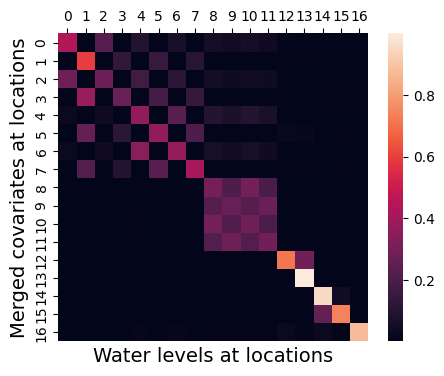

In [36]:
plt.rcParams["figure.figsize"] = (5, 4)
ax = sns.heatmap(atte_score_demo)
ax.xaxis.tick_top()
plt.xlabel("Water levels at locations", fontsize=14)
plt.ylabel("Merged covariates at locations", fontsize=14)
plt.show()

In [ ]:
'MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',

'PUMP_S25B', 'PUMP_S26', 'HWS_S25A', 'HWS_S25B', 'HWS_S26',


'WS_S4', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'

In [ ]:
'MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
'HWS_S25A', 'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'

### Compute attention between inputs and outputs by post_processing

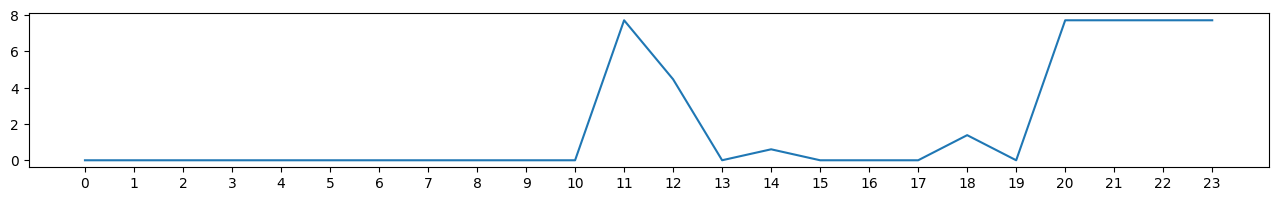

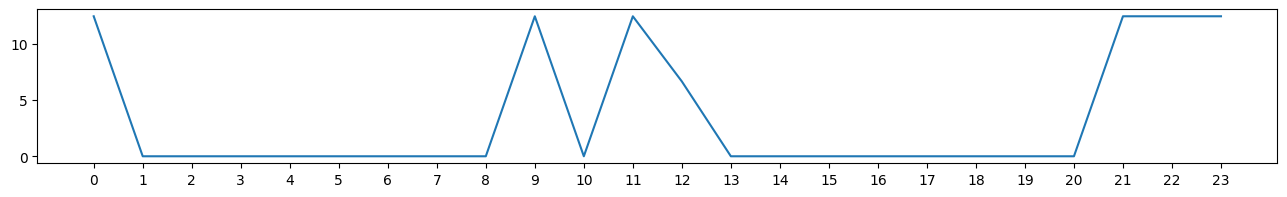

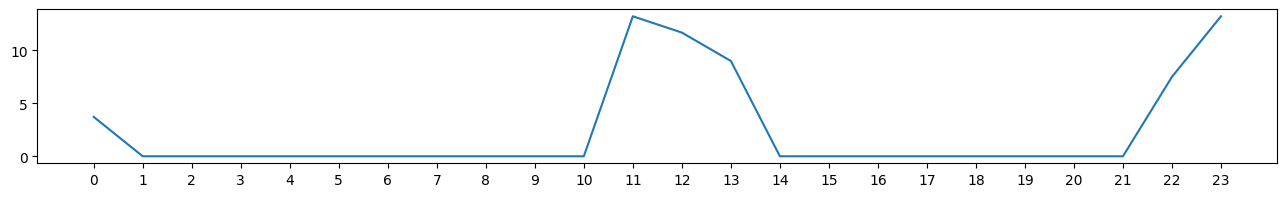

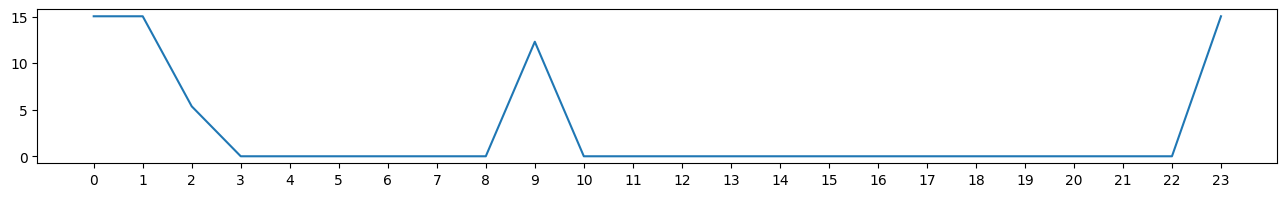

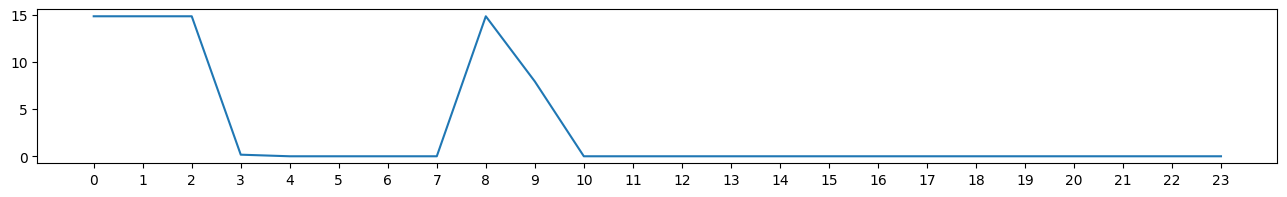

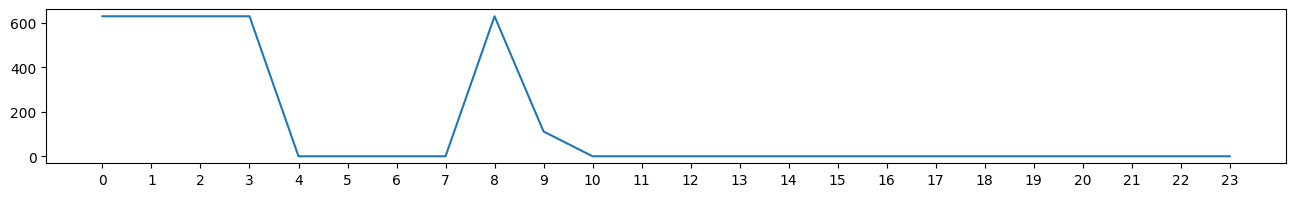

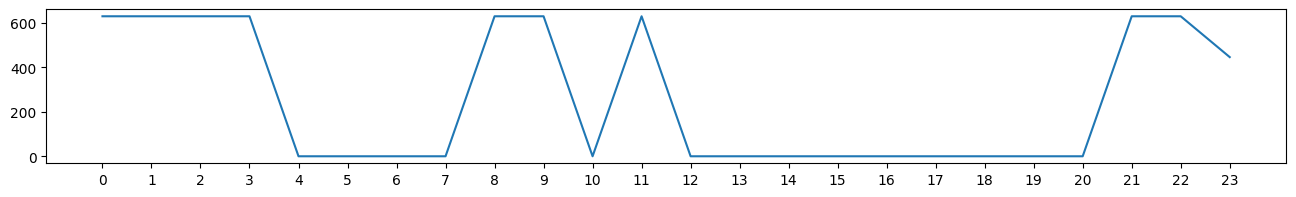

In [222]:
gate_pump_pred_inv = gate_pump_pred_inv.reshape((24, 7))

plt.rcParams["figure.figsize"] = (16, 2)
for i in range(7):
    plt.plot(gate_pump_pred_inv[:, i])
    # plt.tick_params(
    #     axis='x',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     bottom=False,      # ticks along the bottom edge are off
    #     top=False,         # ticks along the top edge are off
    #     labelbottom=False) # labels along the bottom edge are off

    time_ticks = [i for i in range(24)]
    plt.xticks(time_ticks[::1])
    plt.show()
    # plt.title('GATE 0')

Text(0.5, 1.0, 'MEAN_RAIN')

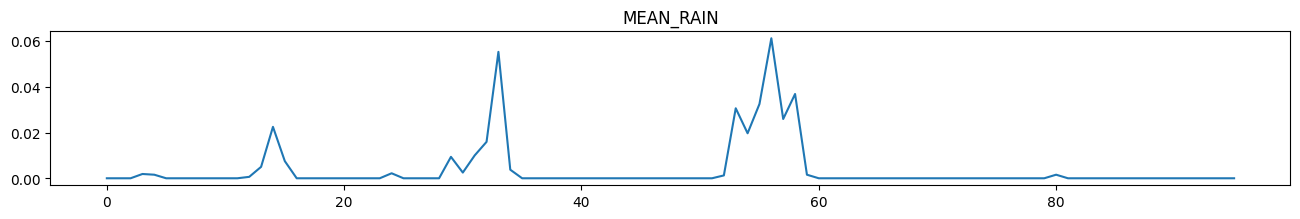

In [119]:
plt.rcParams["figure.figsize"] = (16, 2)
plt.plot(test_X_demo_inv[:, 0])
plt.title('MEAN_RAIN')

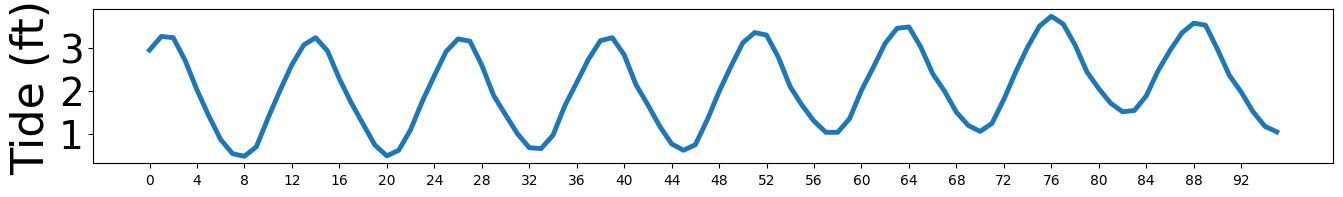

In [272]:
plt.rcParams["figure.figsize"] = (16, 2)
plt.plot(test_X_demo_inv[:, 1], linewidth=3.5)
# plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
# plt.xticks(fontsize=16)
plt.yticks(fontsize=28)
plt.ylabel('Tide (ft)', fontsize=32)
#plt.title('WS_S4')
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
time_ticks = [i for i in range(96)]
plt.xticks(time_ticks[::4])
plt.show()

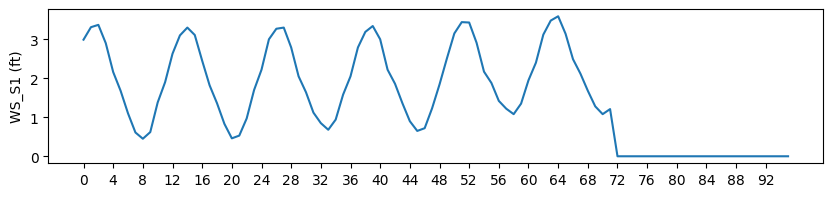

In [116]:
plt.rcParams["figure.figsize"] = (10, 2)

time_ticks = [i for i in range(96)]

plt.plot(test_X_demo_inv[:, -4])
plt.ylabel('WS_S1 (ft)')
plt.xticks(time_ticks[::4])
plt.show()

### Attention between pump and inputs

In [226]:
gate_pump_pred_inv[:, 0+5:1+5].shape

(24, 1)

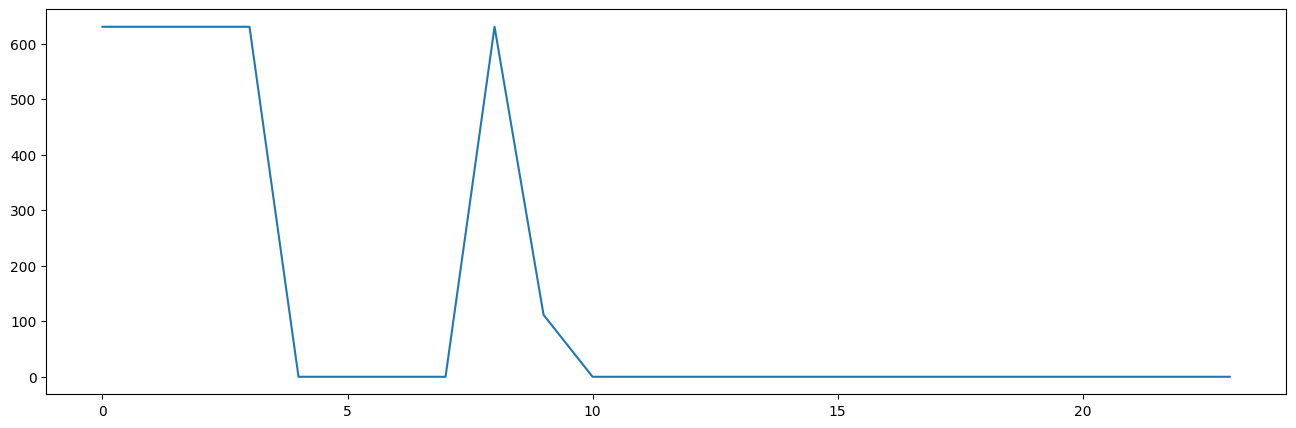

In [227]:
plt.plot(gate_pump_pred_inv[:, 0+5:1+5])

Attention for MEAN_RAIN input:


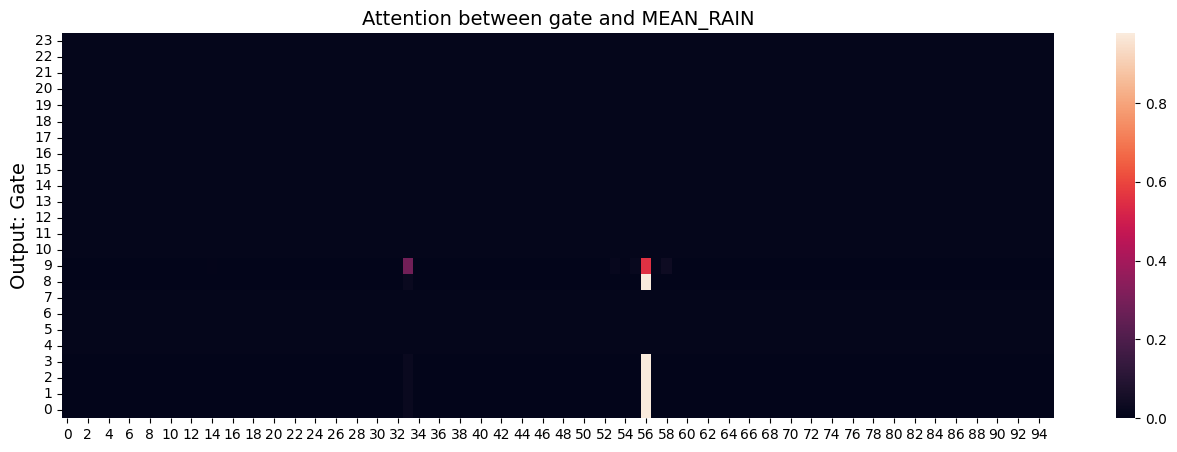

Attention for WS_S4 input:


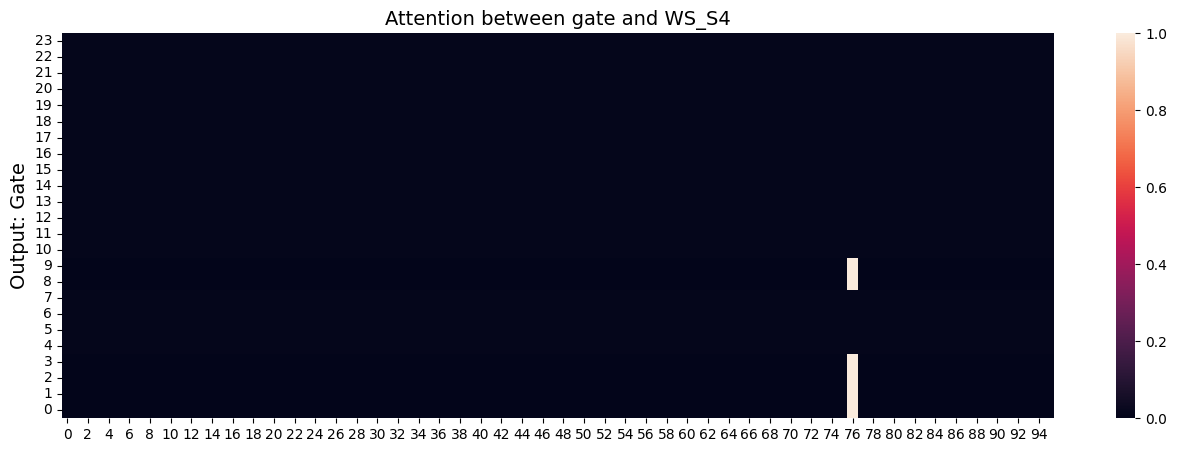

Attention for GATE_S25A input:


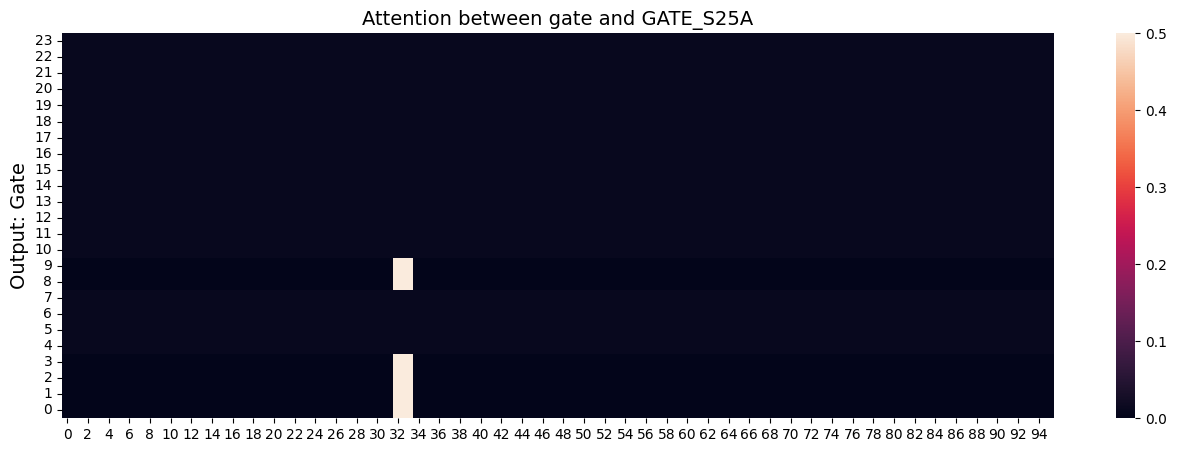

Attention for GATE_S25B input:


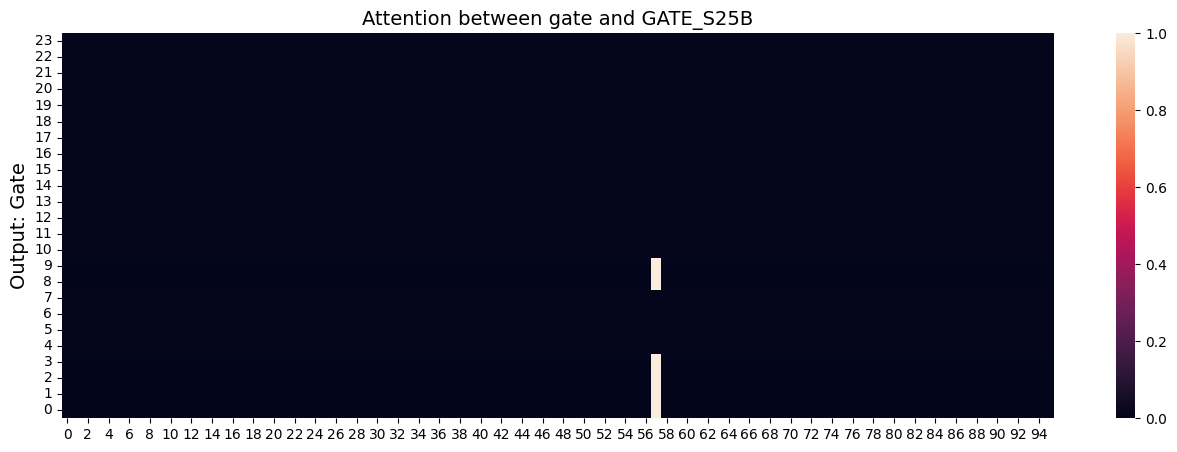

Attention for GATE_S25B2 input:


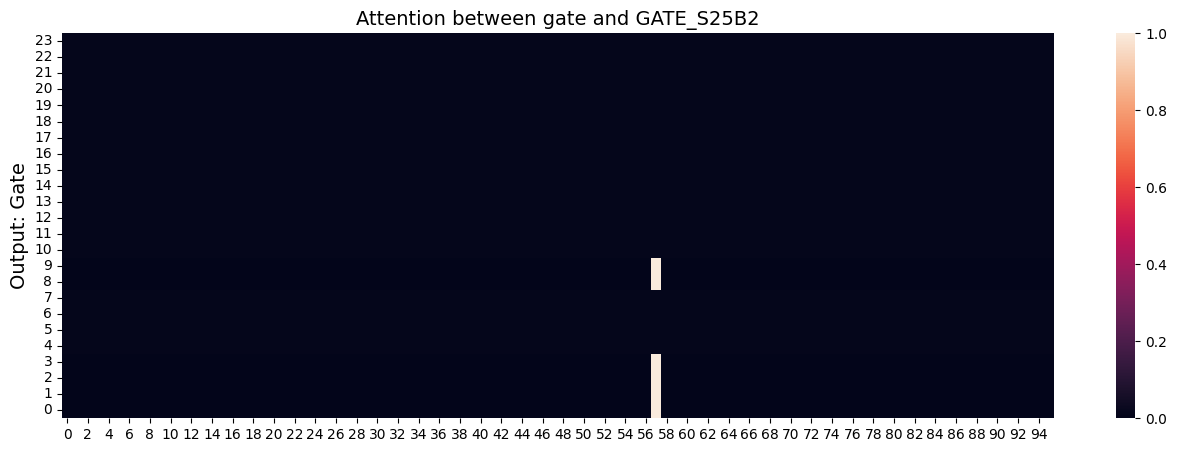

Attention for GATE_S26_1 input:


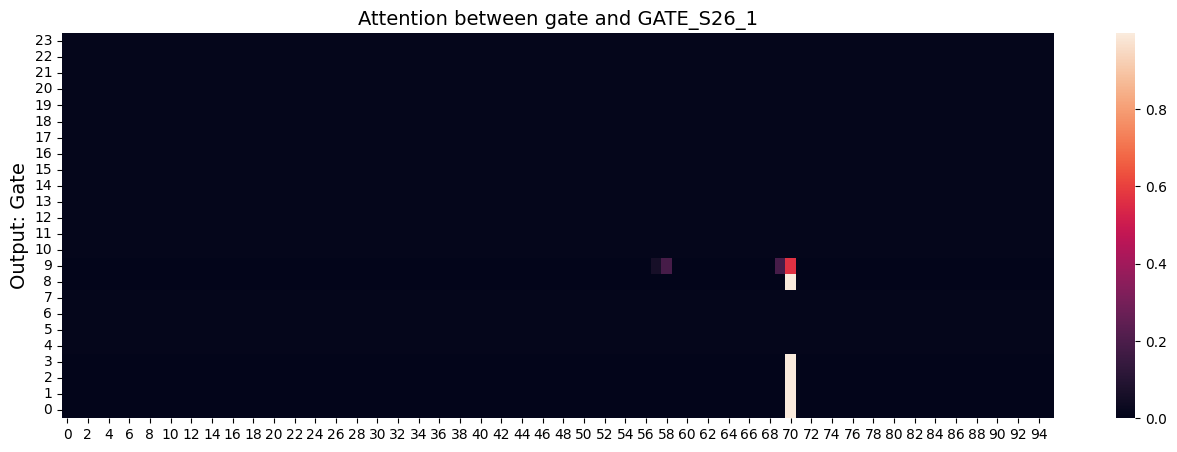

Attention for GATE_S26_2 input:


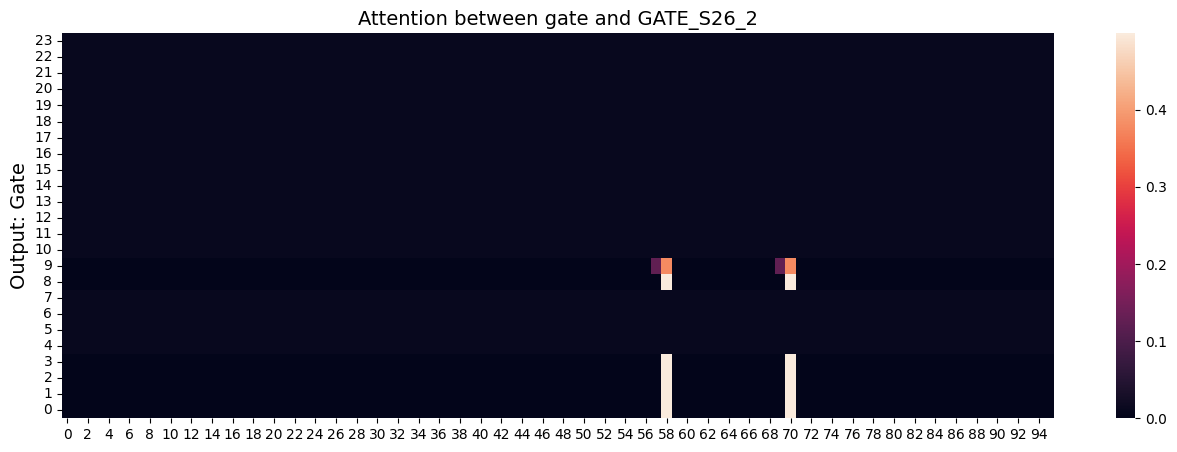

Attention for HWS_S25A input:


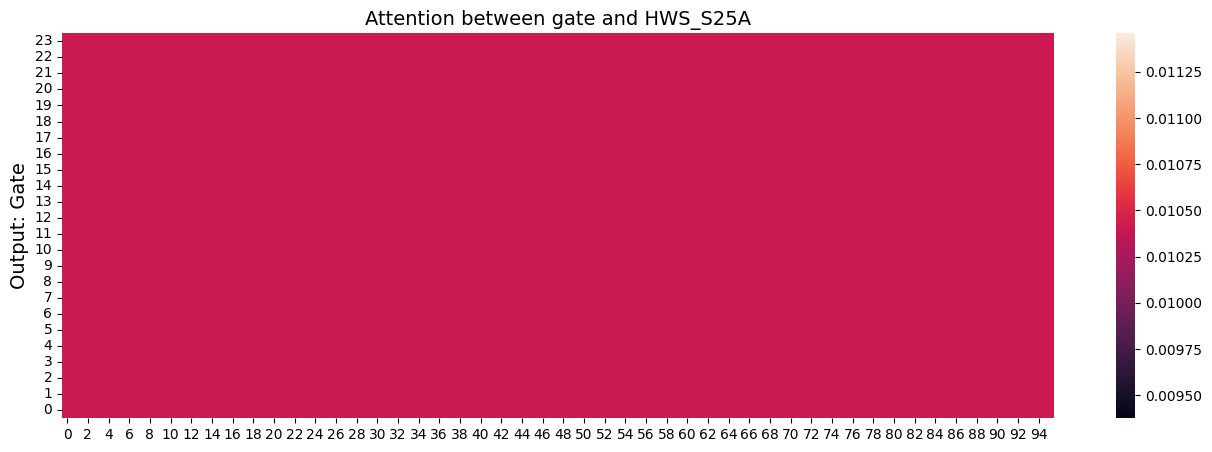

Attention for HWS_S25B input:


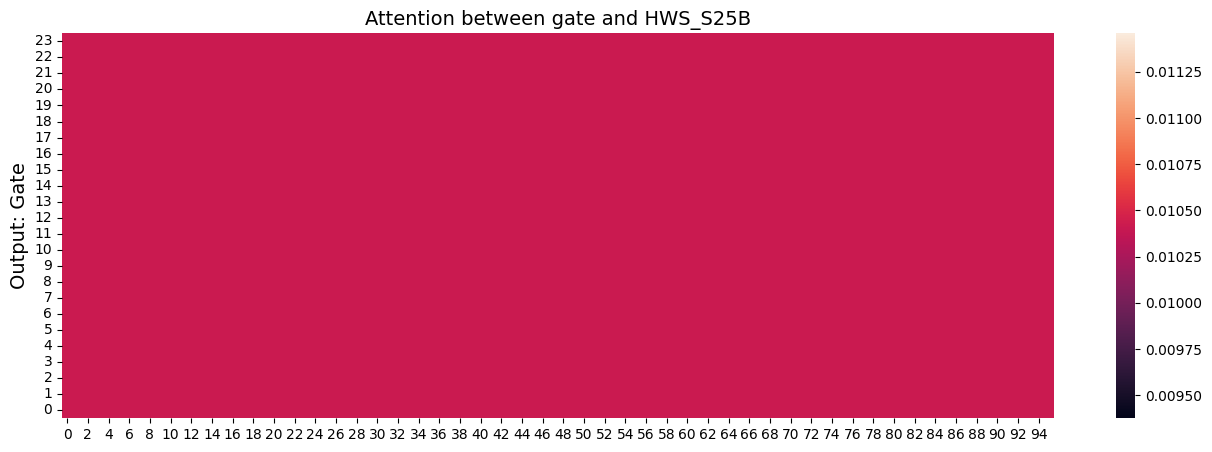

Attention for HWS_S26 input:


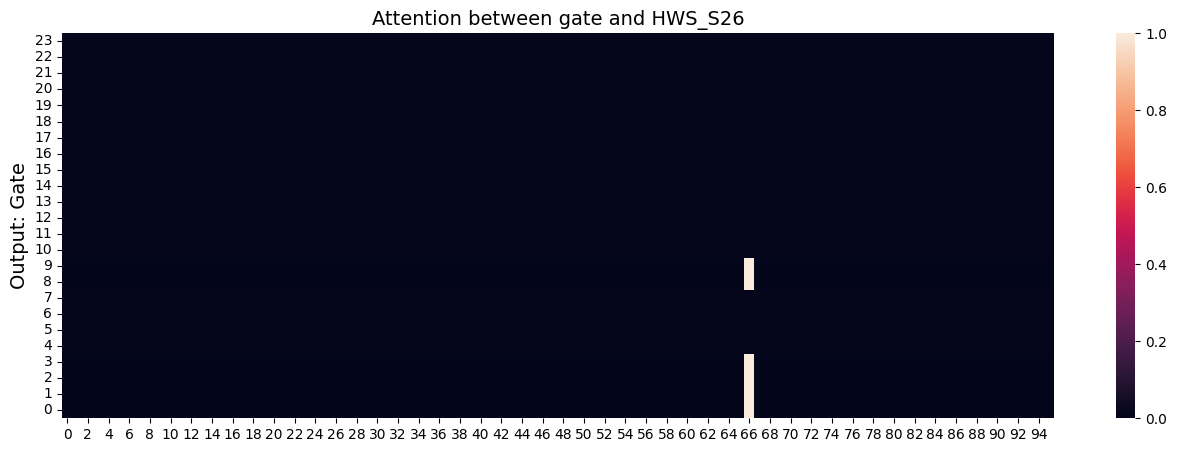

Attention for WS_S1 input:


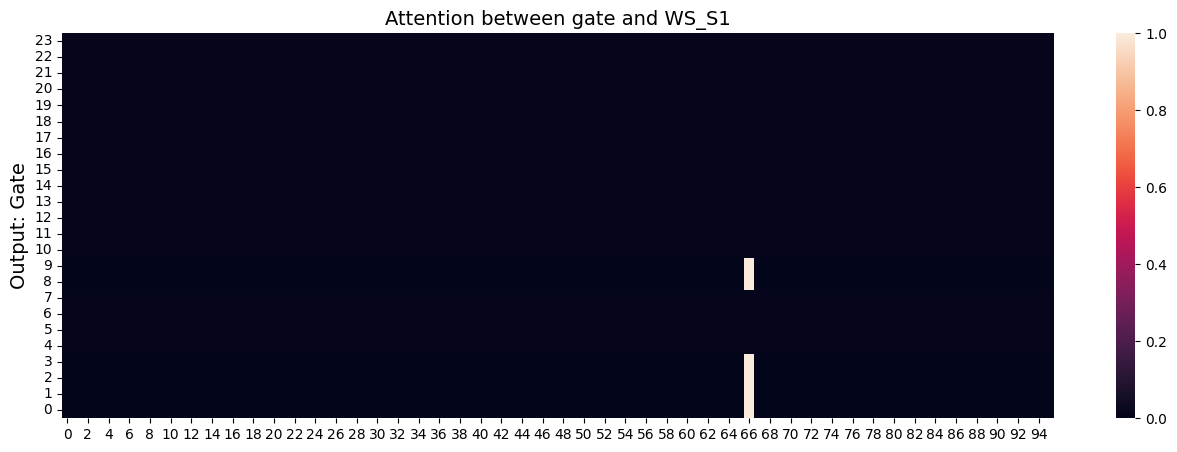

Attention for TWS_S25A input:


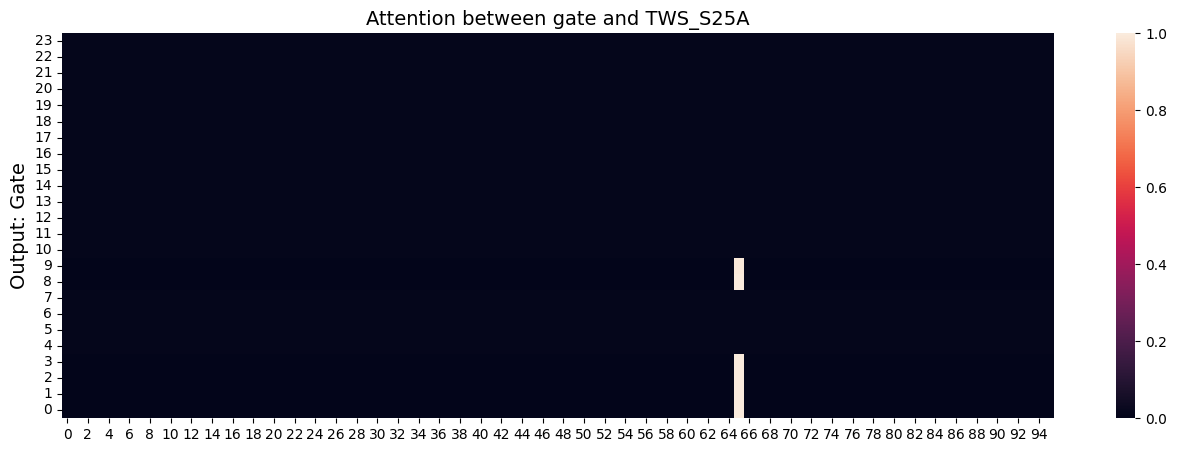

Attention for TWS_S25B input:


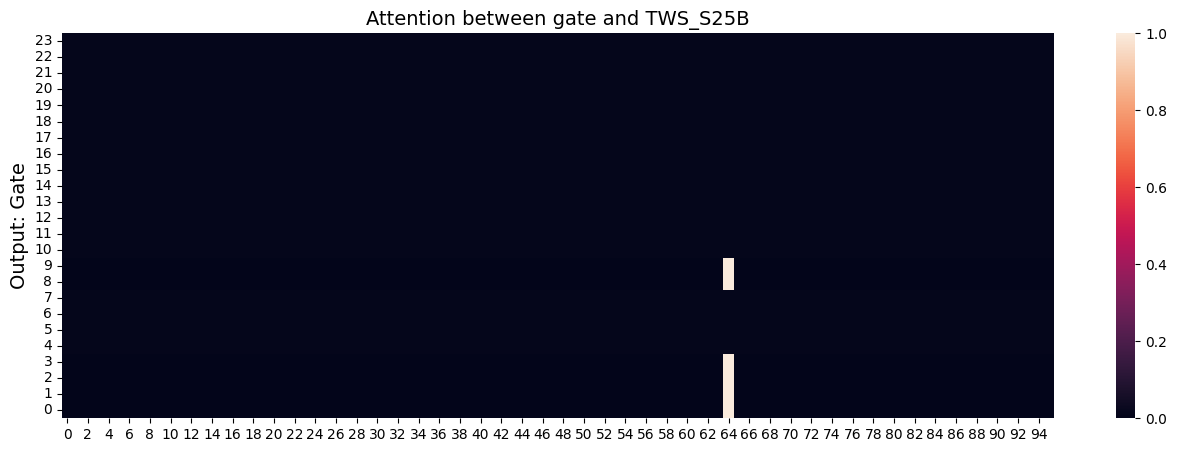

Attention for TWS_S26 input:


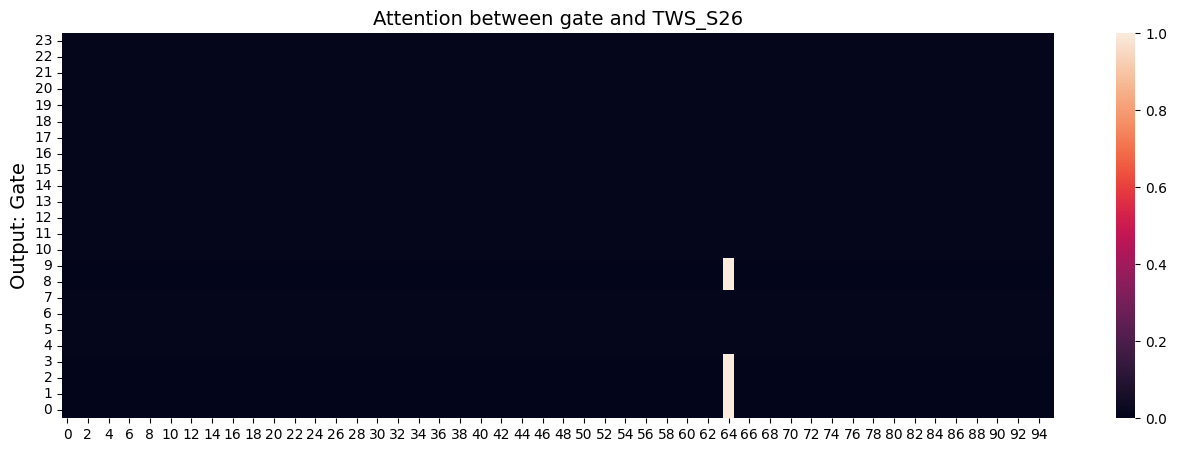

In [225]:
VARS = ['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
        'HWS_S25A', 'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

time_ticks = [i for i in range(24)]
# plt.xticks(time_ticks[::1])


FONTSIZE = 14

for i in range(len(VARS)):
    print("Attention for {} input:".format(VARS[i]))
    atte_opt, atte_score = layers.Attention()([gate_pump_pred_inv[:, 0+5:1+5], test_X_demo_inv[:, i:i+1]], return_attention_scores=True)
    plt.rcParams["figure.figsize"] = (16, 5)

    ax = sns.heatmap(atte_score[::-1])   # , cmap="crest"
#     ax.xaxis.tick_top()

    ax.set_yticks(np.arange(23.5, -0.5, -1))
    ax.set_yticklabels(np.arange(0, 24, 1))

    plt.ylabel("Output: Gate", fontsize=FONTSIZE)
    plt.title("Attention between gate and {}".format(VARS[i]), fontsize=FONTSIZE)
    plt.show()

### attention between gate and inputs

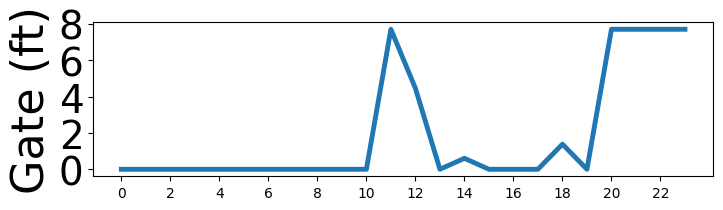

In [266]:
# plt.plot(gate_pump_pred_inv[:, 0:1])

plt.rcParams["figure.figsize"] = (8, 2)
plt.plot(gate_pump_pred_inv[:, 0:1], linewidth=3.5)
#plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
# plt.xticks(fontsize=16)
plt.yticks(fontsize=28)
plt.ylabel('Gate (ft)', fontsize=32)
#plt.title('WS_S4')
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
time_ticks = [i for i in range(24)]
plt.xticks(time_ticks[::2])
plt.show()

Attention for MEAN_RAIN input:


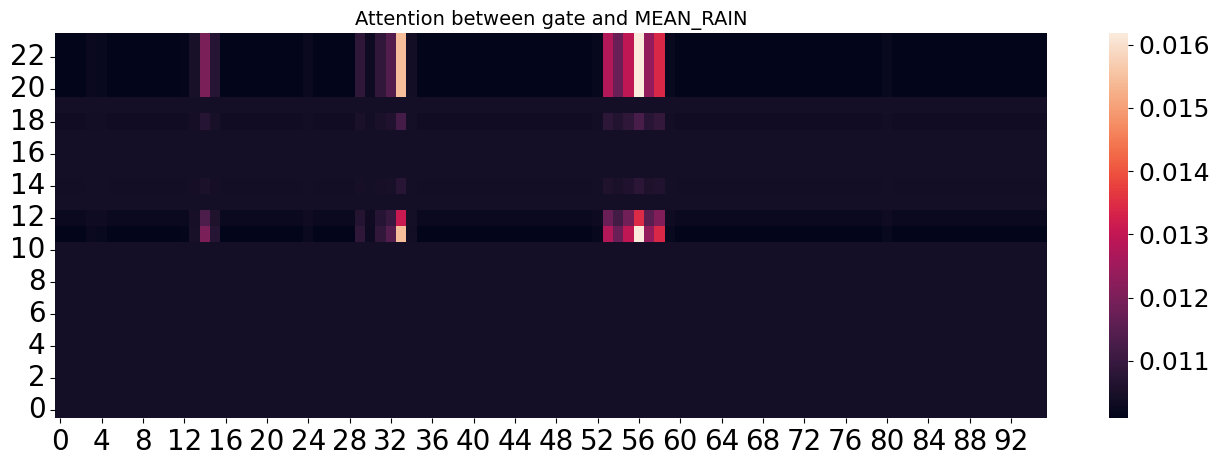

Attention for WS_S4 input:


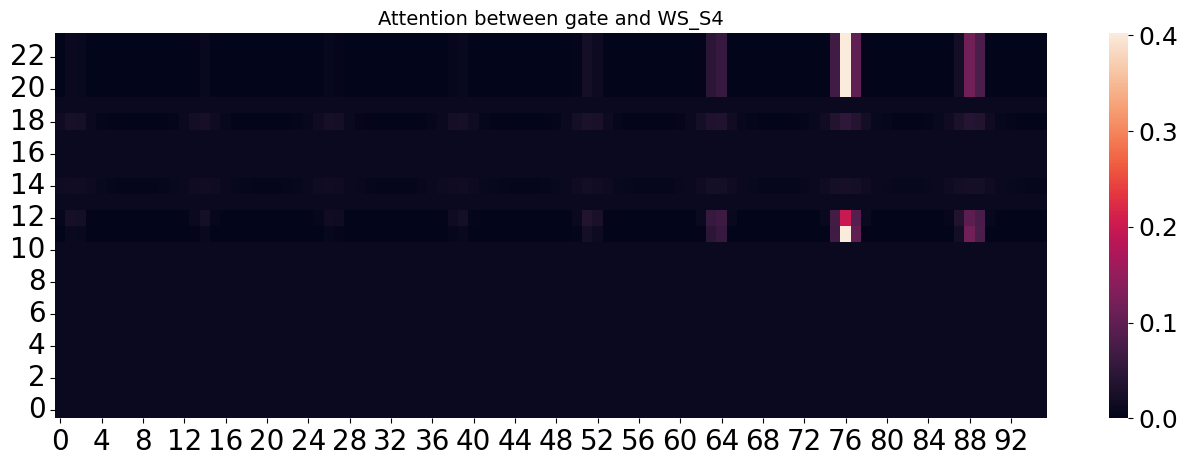

Attention for GATE_S25A input:


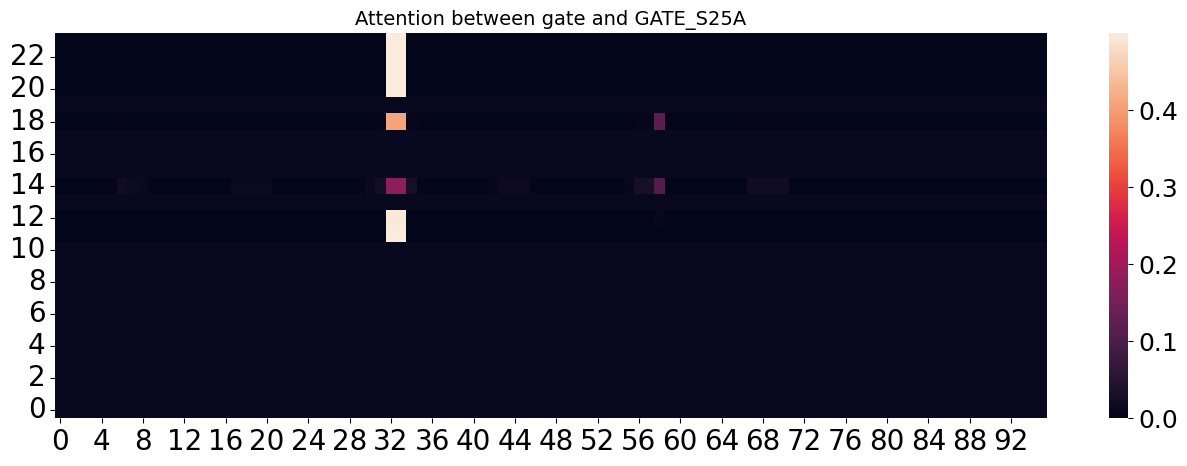

Attention for GATE_S25B input:


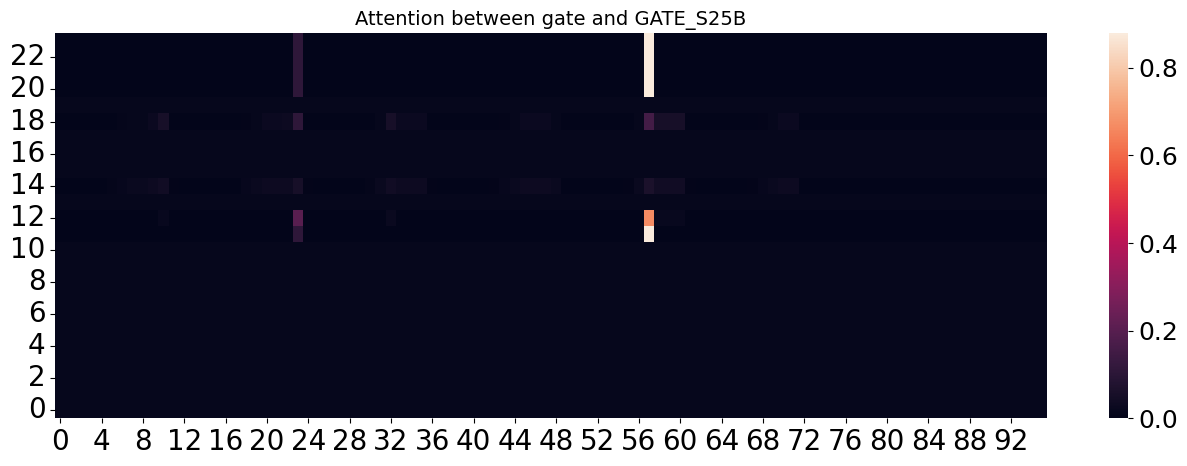

Attention for GATE_S25B2 input:


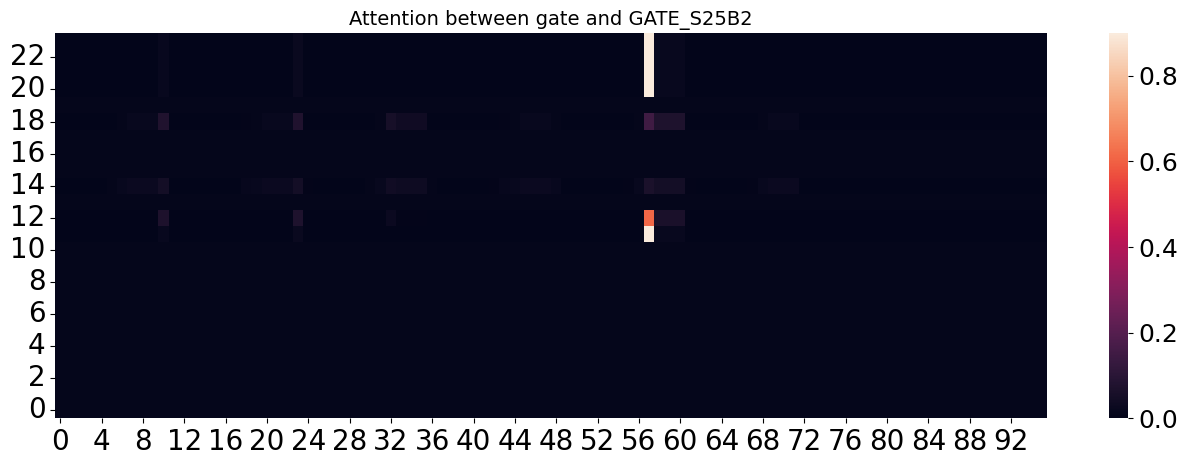

Attention for GATE_S26_1 input:


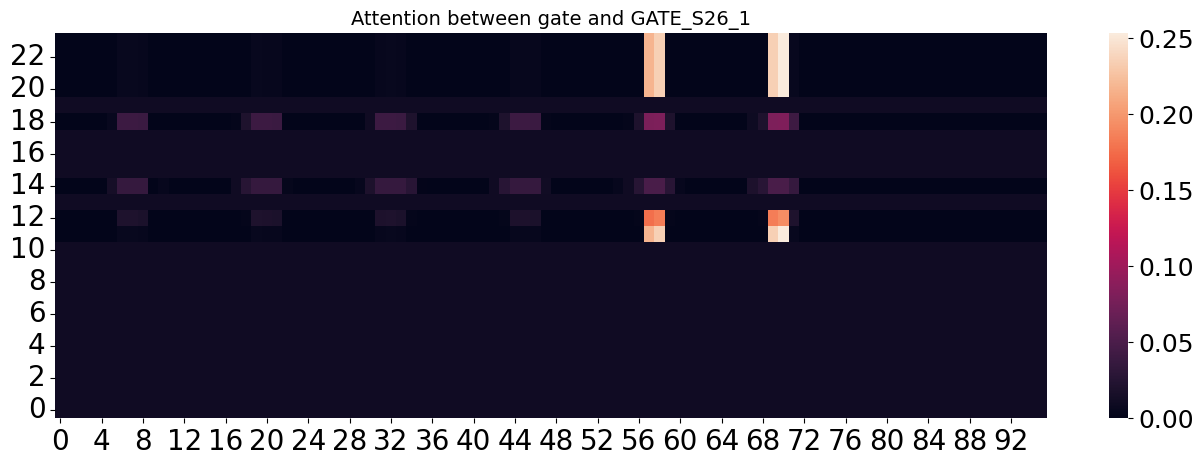

Attention for GATE_S26_2 input:


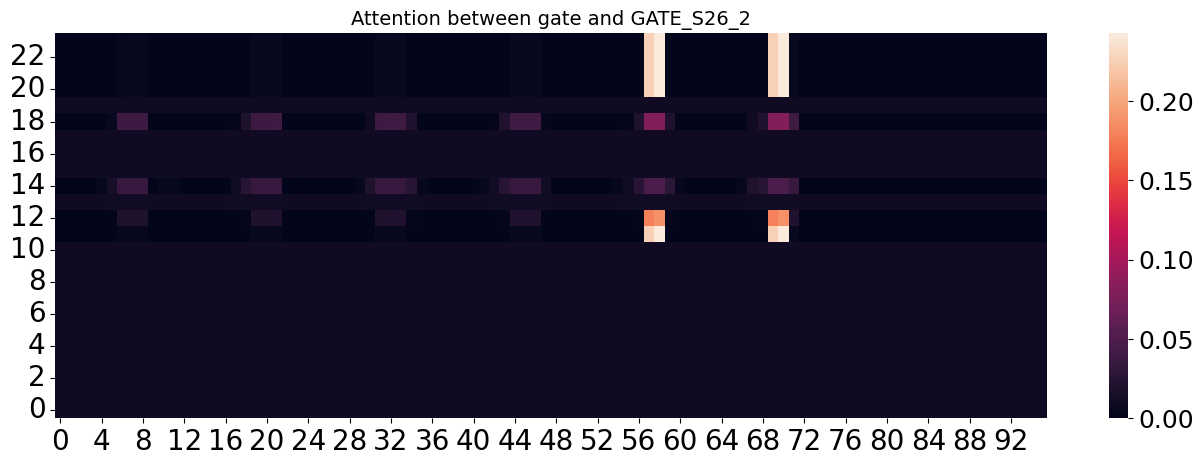

Attention for HWS_S25A input:


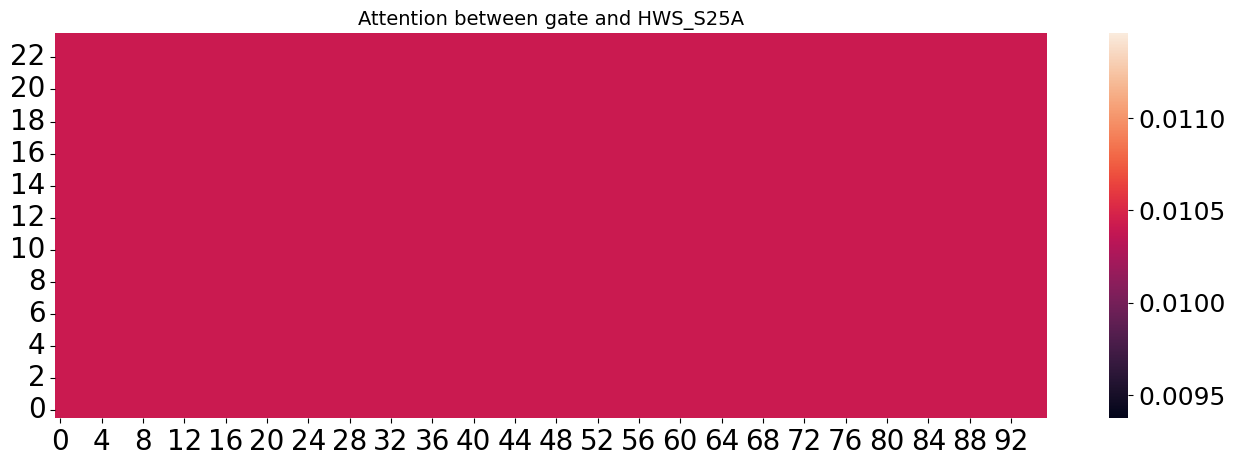

Attention for HWS_S25B input:


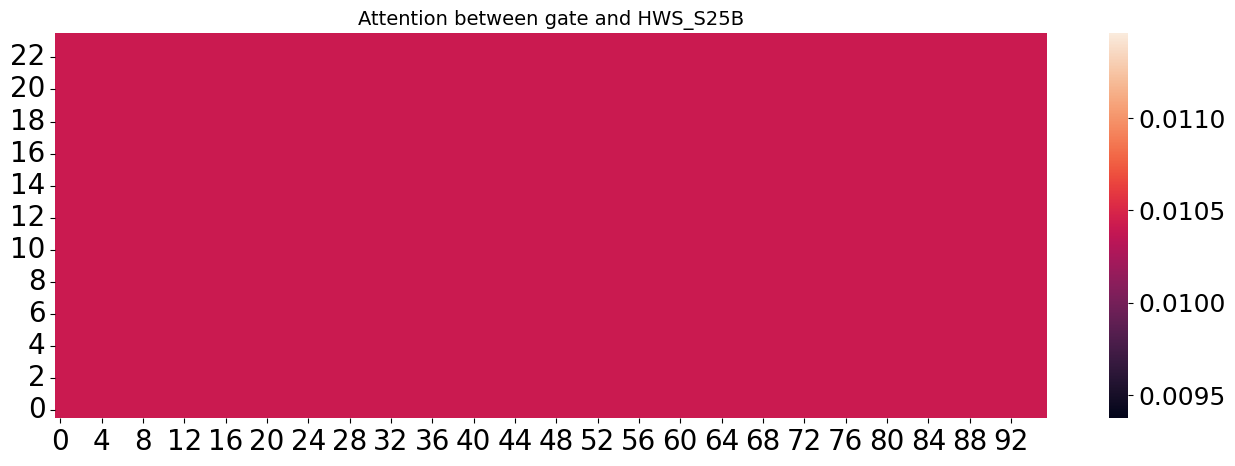

Attention for HWS_S26 input:


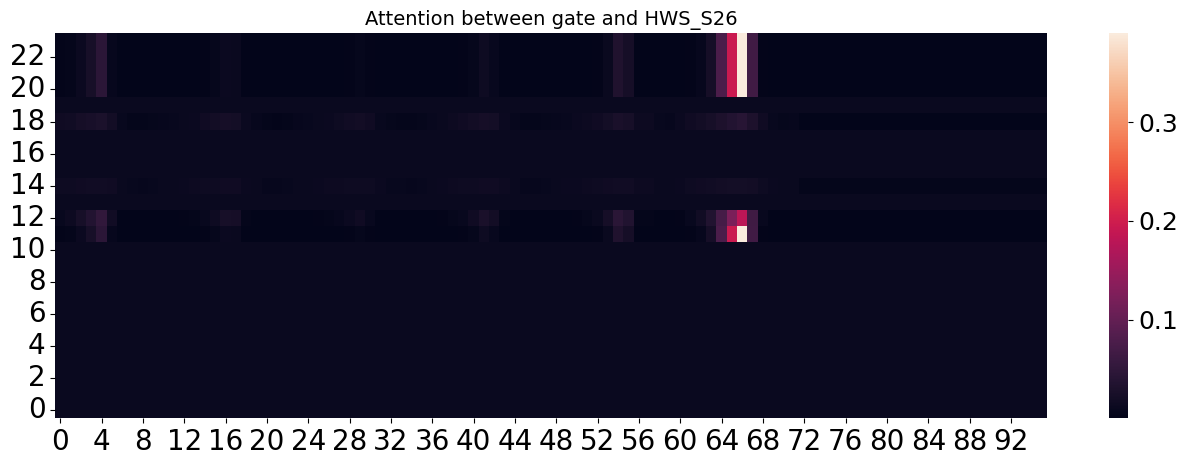

Attention for WS_S1 input:


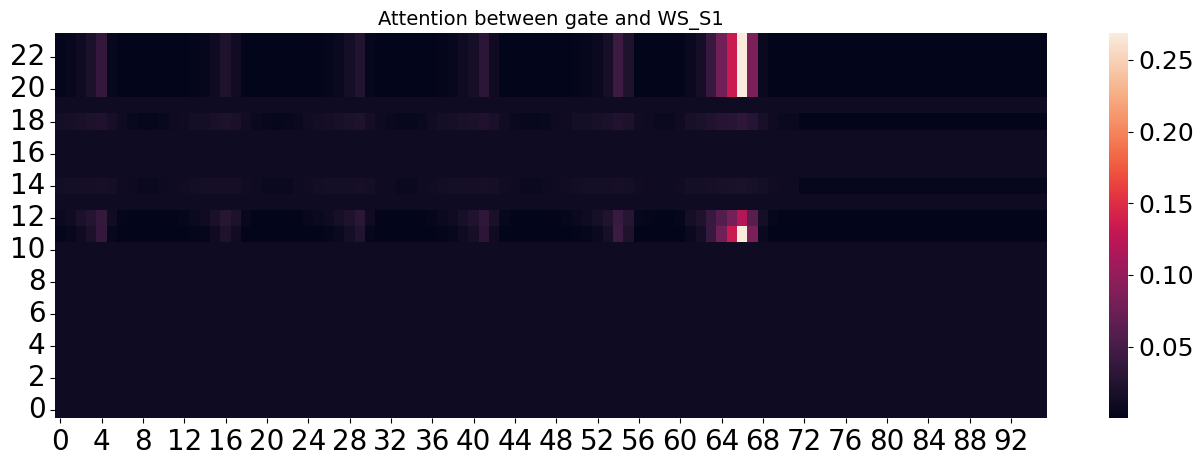

Attention for TWS_S25A input:


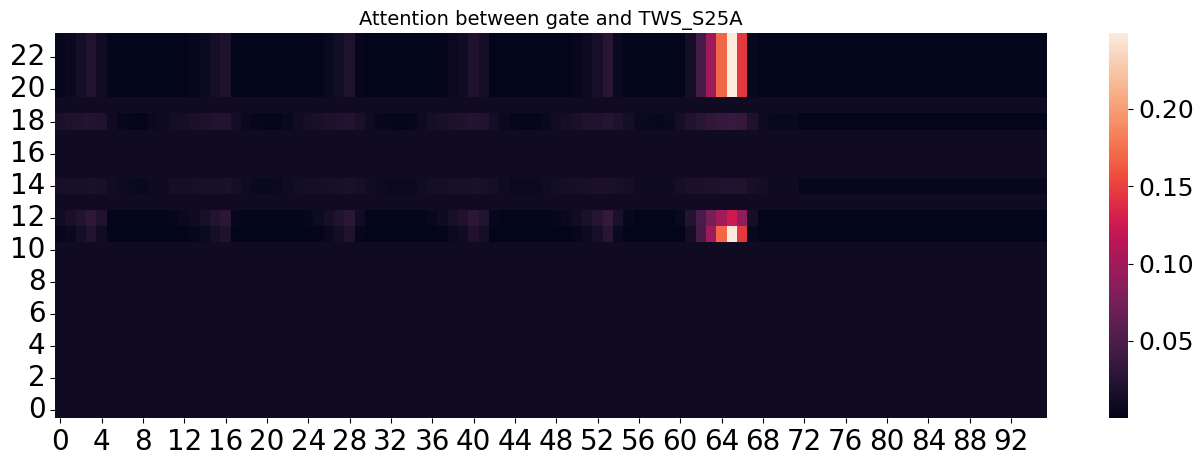

Attention for TWS_S25B input:


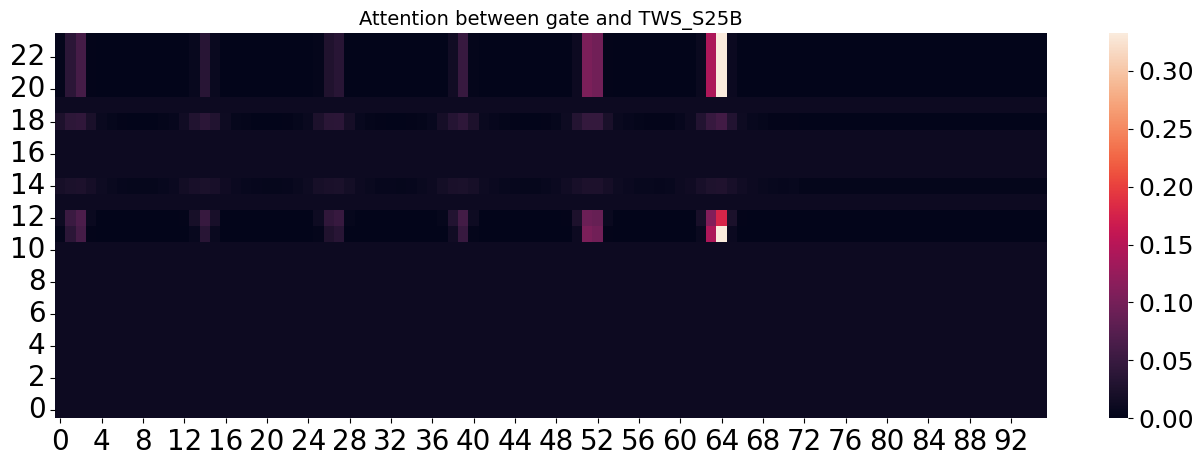

Attention for TWS_S26 input:


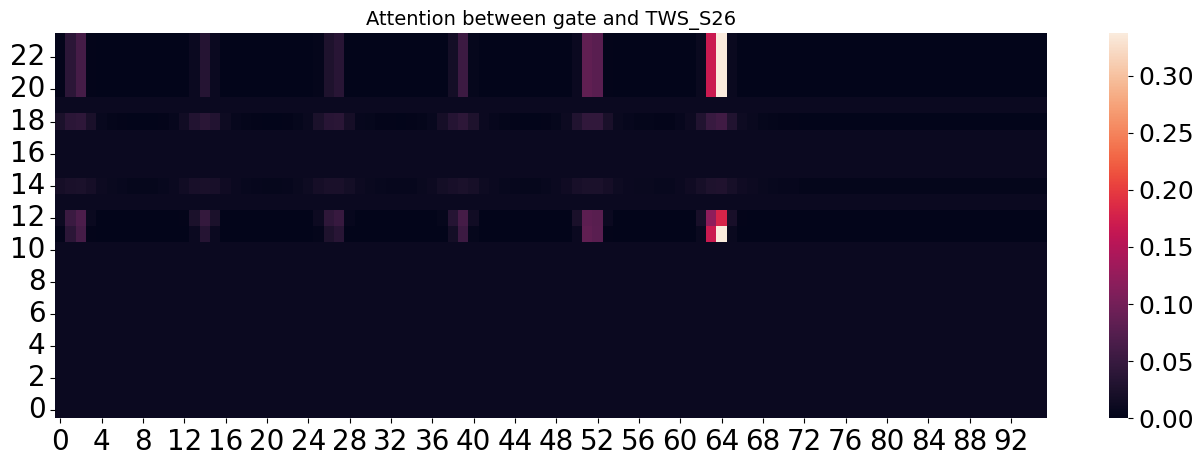

In [268]:
VARS = ['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
        'HWS_S25A', 'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

time_ticks = [i for i in range(24)]
# plt.xticks(time_ticks[::1])


TICK_FONTSIZE = 20
LABEL_FONTSIZE = 16

for i in range(len(VARS)):
    print("Attention for {} input:".format(VARS[i]))
    atte_opt, atte_score = layers.Attention()([gate_pump_pred_inv[:, 0:1], test_X_demo_inv[:, i:i+1]], return_attention_scores=True)
    plt.rcParams["figure.figsize"] = (16, 5)

    ax = sns.heatmap(atte_score[::-1])   # , cmap="crest"
#     ax.xaxis.tick_top()
    
    
    ax.set_xticks(np.arange(0.5, 95.5, 4))
    ax.set_xticklabels(np.arange(0, 96, 4), fontsize=TICK_FONTSIZE)
    ax.set_yticks(np.arange(23.5, -0.5, -2))
    ax.set_yticklabels(np.arange(0, 24, 2), fontsize=TICK_FONTSIZE)

    #plt.xlabel("Time (hr)", fontsize=LABEL_FONTSIZE)
    #plt.ylabel("Gate Opening (ft)", fontsize=LABEL_FONTSIZE)
    plt.title("Attention between gate and {}".format(VARS[i]), fontsize=FONTSIZE)
    
    # Adjust the size of the color bar
    cbar = ax.collections[0].colorbar  # Get the color bar object
    cbar.ax.tick_params(labelsize=18)  # Adjust the tick label font size

    
    plt.show()

### Integrated Gradients

In [201]:
input_id = 1

def integrated_gradients(model, input_data_list, baseline_data_list, num_steps=50):
    
    # Convert input and baseline data to tensors
    input_tensors = [tf.convert_to_tensor(data, dtype=tf.float32) for data in input_data_list]
    baseline_tensors = [tf.convert_to_tensor(data, dtype=tf.float32) for data in baseline_data_list]

    # Compute the gradients of the model's output with respect to the input
    with tf.GradientTape() as tape:
        tape.watch(input_tensors[input_id])
        predictions = model(input_tensors)
    gradients = tape.gradient(predictions, input_tensors[input_id])

    # Calculate the difference between input and baseline
    input_diff = input_tensors[input_id] - baseline_tensors[input_id]

    # Initialize an array to store the integrated gradients
    integrated_gradients = np.zeros_like(input_tensors[input_id])

    # Compute integrated gradients for each step
    for step in range(num_steps):
        # Interpolate between baseline and input
        interpolated_input = baseline_tensors[input_id] + (input_diff * step / num_steps)
        baseline_tensors[input_id] = interpolated_input
        
        # Compute gradients at the interpolated input
        with tf.GradientTape() as tape:
            tape.watch(interpolated_input)
            interpolated_predictions = model(baseline_tensors)
        interpolated_gradients = tape.gradient(interpolated_predictions, interpolated_input)

        # Accumulate the gradients to compute integrated gradients
        integrated_gradients += interpolated_gradients

    # Average the accumulated gradients and multiply by input difference
    integrated_gradients *= input_diff / num_steps

    # Return the computed integrated gradients
    return integrated_gradients


In [202]:
input_data = [test_cov[demo:demo+1, :, :], test_tws_reshape[demo:demo+1, :, :], test_adj_mat[demo:demo+1, :, :]]
baseline_data = [np.zeros((1, 96, 12), dtype=np.float32), np.zeros((1, 5, 72), dtype=np.float32), np.zeros((1, 5, 5), dtype=np.float32)] 

# Compute integrated gradients
attributions = integrated_gradients(gate_predictor_trained, input_data, baseline_data)

attributions

<tf.Tensor: shape=(1, 5, 72), dtype=float32, numpy=
array([[[ 5.28149791e-02, -1.66690871e-01, -1.24818273e-01,
         -9.48736817e-02,  1.32336378e-01, -8.45081061e-02,
         -2.85588354e-01, -1.49564028e-01,  8.33450556e-02,
         -1.70133874e-01, -5.15701845e-02,  1.20774135e-02,
         -1.95481747e-01, -1.89521000e-01, -2.47968510e-01,
         -7.06059113e-03, -1.59231529e-01, -1.10974610e-01,
         -2.21552178e-01, -2.15813801e-01, -1.85544819e-01,
         -8.26844051e-02, -1.27658740e-01, -2.13631853e-01,
         -2.82509681e-02,  3.31737823e-03,  2.67169960e-02,
          2.54182313e-02,  8.97841081e-02, -3.70500572e-02,
         -2.02846620e-02, -2.87977085e-02, -1.17673941e-01,
          7.97060952e-02,  2.36316212e-02, -3.44064385e-02,
          3.46746966e-02,  6.70259371e-02,  8.31164792e-02,
          4.88029383e-02,  1.74711198e-02, -5.22328913e-02,
          6.23461641e-02,  9.60906153e-04, -2.67273057e-02,
          3.87655608e-02,  5.39914332e-02, -1.98

In [206]:
attributions_array = attributions.numpy()
attribute_matrix = attributions_array.reshape((72, 5))
print(attribute_matrix.shape)


feature_matrix = input_data[1]
feature_matrix = feature_matrix.reshape((72, 5))
print(feature_matrix.shape)

(72, 5)
(72, 5)


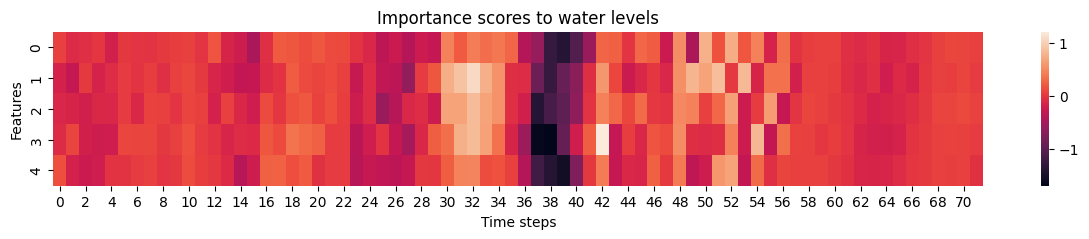

In [216]:
# Create a heatmap
plt.rcParams["figure.figsize"] = (15, 2)
sns.heatmap(attribute_matrix.T)

# Add labels and title
plt.ylabel("Features")
plt.xlabel("Time steps")
plt.title("Importance scores to water levels")

# Display the plot
plt.show()

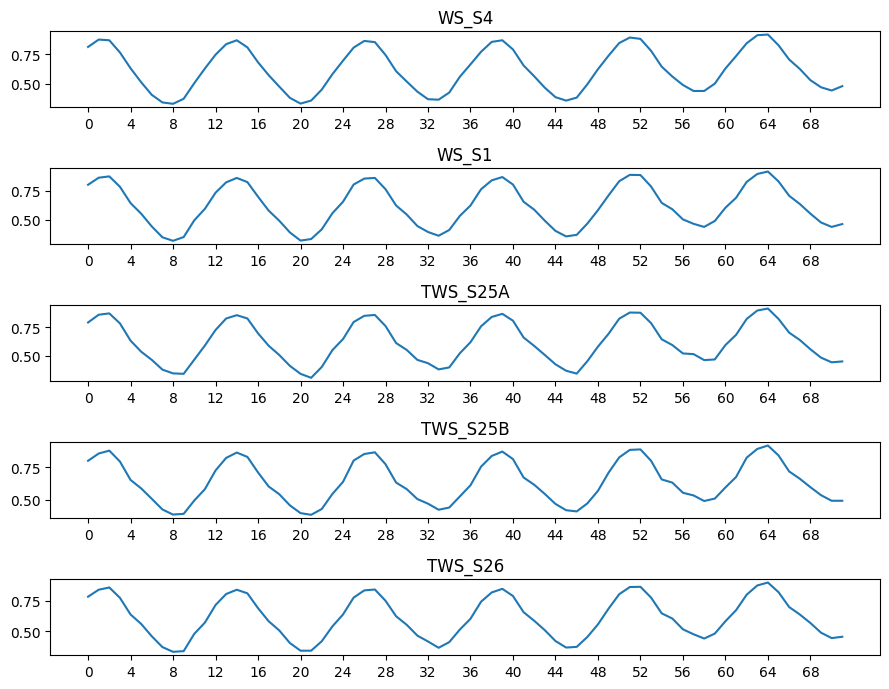

In [215]:
INPUTS = ['WS_S4', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

plt.rcParams["figure.figsize"] = (9, 7)
fig = plt.figure(tight_layout=True)
gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)


for i in range(len(INPUTS)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(feature_matrix[:, i], linewidth=1.5)
    ax.set_title('{}'.format(INPUTS[i]), fontsize=12)
    plt.xticks(np.arange(0, 72, 4))
    
# plt.savefig('INPUTS.png', dpi=300, bbox_inches='tight')
plt.show()

In [217]:
input_id = 0

def integrated_gradients(model, input_data_list, baseline_data_list, num_steps=50):
    
    # Convert input and baseline data to tensors
    input_tensors = [tf.convert_to_tensor(data, dtype=tf.float32) for data in input_data_list]
    baseline_tensors = [tf.convert_to_tensor(data, dtype=tf.float32) for data in baseline_data_list]

    # Compute the gradients of the model's output with respect to the input
    with tf.GradientTape() as tape:
        tape.watch(input_tensors[input_id])
        predictions = model(input_tensors)
    gradients = tape.gradient(predictions, input_tensors[input_id])

    # Calculate the difference between input and baseline
    input_diff = input_tensors[input_id] - baseline_tensors[input_id]

    # Initialize an array to store the integrated gradients
    integrated_gradients = np.zeros_like(input_tensors[input_id])

    # Compute integrated gradients for each step
    for step in range(num_steps):
        # Interpolate between baseline and input
        interpolated_input = baseline_tensors[input_id] + (input_diff * step / num_steps)
        baseline_tensors[input_id] = interpolated_input
        
        # Compute gradients at the interpolated input
        with tf.GradientTape() as tape:
            tape.watch(interpolated_input)
            interpolated_predictions = model(baseline_tensors)
        interpolated_gradients = tape.gradient(interpolated_predictions, interpolated_input)

        # Accumulate the gradients to compute integrated gradients
        integrated_gradients += interpolated_gradients

    # Average the accumulated gradients and multiply by input difference
    integrated_gradients *= input_diff / num_steps

    # Return the computed integrated gradients
    return integrated_gradients


In [218]:
input_data = [test_cov[demo:demo+1, :, :], test_tws_reshape[demo:demo+1, :, :], test_adj_mat[demo:demo+1, :, :]]
baseline_data = [np.zeros((1, 96, 12), dtype=np.float32), np.zeros((1, 5, 72), dtype=np.float32), np.zeros((1, 5, 5), dtype=np.float32)] 

# Compute integrated gradients
attributions = integrated_gradients(gate_predictor_trained, input_data, baseline_data)

attributions

<tf.Tensor: shape=(1, 96, 12), dtype=float32, numpy=
array([[[ 0.        ,  0.11246431,  0.        , ..., -0.00292293,
          0.01632986,  0.01940298],
        [ 0.        ,  0.32876256,  0.        , ...,  0.02064504,
          0.01478958,  0.02979289],
        [ 0.        ,  0.2363287 ,  0.        , ..., -0.00331374,
          0.01529879,  0.01744336],
        ...,
        [-0.        ,  0.40066397, -0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.254119  ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.18617925,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)>

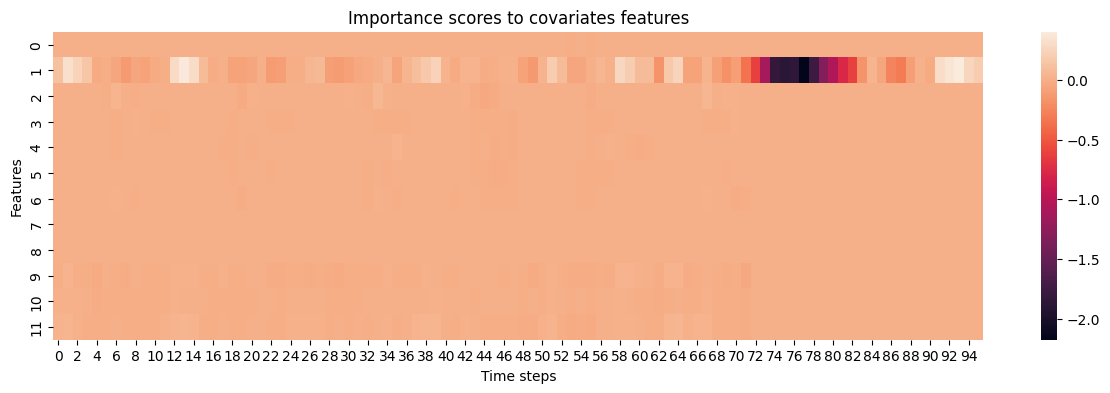

In [220]:
# Create a heatmap
plt.rcParams["figure.figsize"] = (15, 4)
sns.heatmap(attribute_matrix.T)

# Add labels and title
plt.ylabel("Features")
plt.xlabel("Time steps")
plt.title("Importance scores to covariates features")

# Display the plot
plt.show()

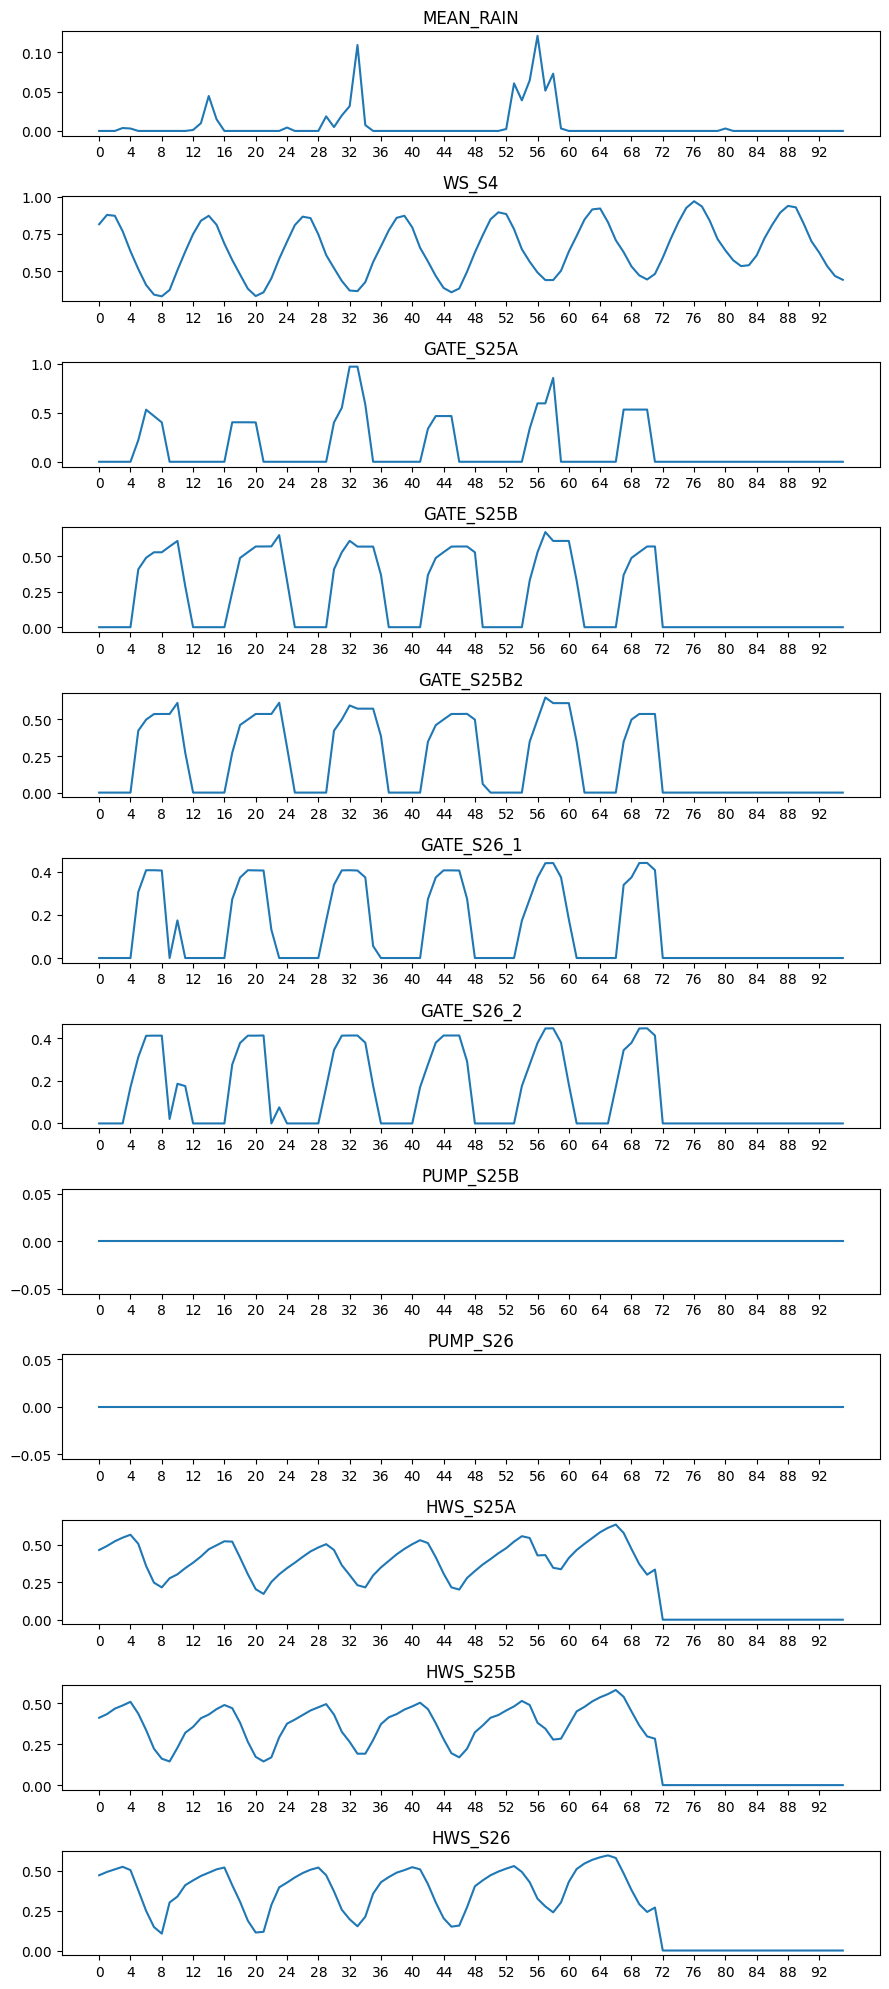

In [221]:
attributions_array = attributions.numpy()
attribute_matrix = attributions_array.reshape((96, 12))

feature_matrix = input_data[0]
feature_matrix = feature_matrix.reshape((96, 12))


INPUTS = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          'HWS_S25A', 'HWS_S25B', 'HWS_S26']

plt.rcParams["figure.figsize"] = (9, 20)
fig = plt.figure(tight_layout=True)
gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)


for i in range(len(INPUTS)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(feature_matrix[:, i], linewidth=1.5)
    ax.set_title('{}'.format(INPUTS[i]), fontsize=12)
    plt.xticks(np.arange(0, 96, 4))
    
# plt.savefig('INPUTS.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
saved_model = load_model('../saved_models/transformer_transformer.h5',
                         custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}
                        )

In [32]:
saved_model.summary()

Model: "filda"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          [(None, 96, 16)]     0                                            
__________________________________________________________________________________________________
gate_predictor (Functional)     (None, 24, 7)        12327       input_seq[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 24, 2)        0           input_seq[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 24, 7)        0           input_seq[0][0]                  
______________________________________________________________________________________________

In [14]:
gate_pump_pred, ws_pred = saved_model.predict(test_X_mask)

print(gate_pump_pred.shape)

print(ws_pred.shape)

(19268, 24, 7)
(19268, 96)


In [15]:
gate_pump_pred_reshape = gate_pump_pred.reshape((-1, 24*7))
gate_pump_pred_inv = gate_pump_scaler.inverse_transform(gate_pump_pred_reshape)
gate_pump_pred_inv = gate_pump_pred_inv.reshape((-1, 24, 7))
print(gate_pump_pred_inv.shape)

(19268, 24, 7)


In [16]:
demo = 18000

# prediction
gate_pump_pred_demo = gate_pump_pred[demo]
gate_pump_pred_demo = gate_pump_pred_demo.reshape((24*7, 1))


# original data
original_input_demo = test_X_mask[demo]
original_input_demo = original_input_demo.reshape((1, 96*16))
original_input_demo = scaler.inverse_transform(original_input_demo)
original_input_demo = original_input_demo.reshape((96, 16))

print(gate_pump_pred_demo.shape, original_input_demo.shape)

(168, 1) (96, 16)


Attention for MEAN_RAIN input:


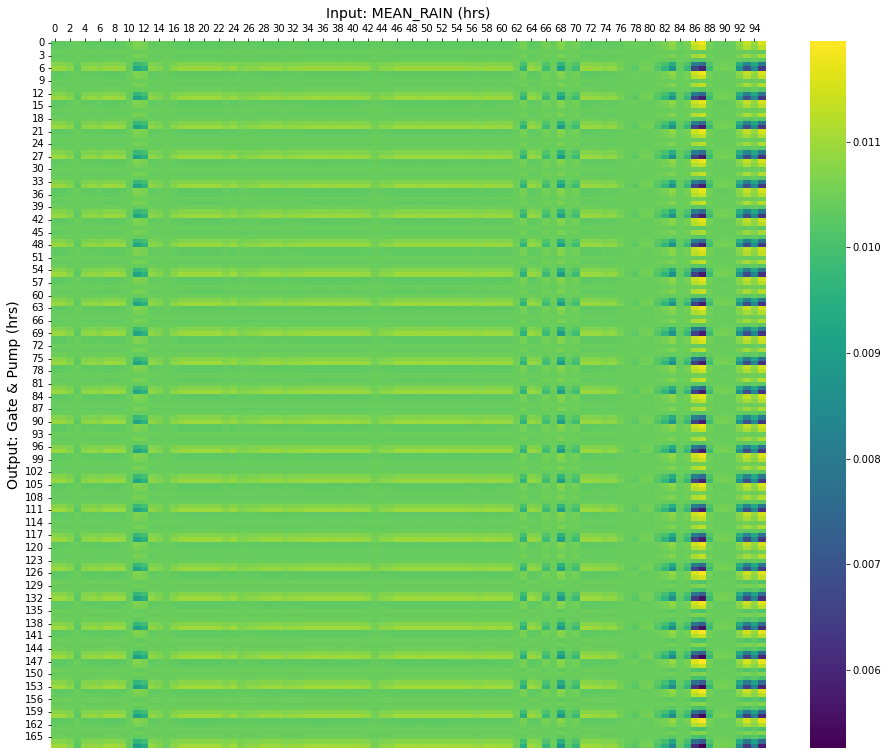

Attention for WS_S4 input:


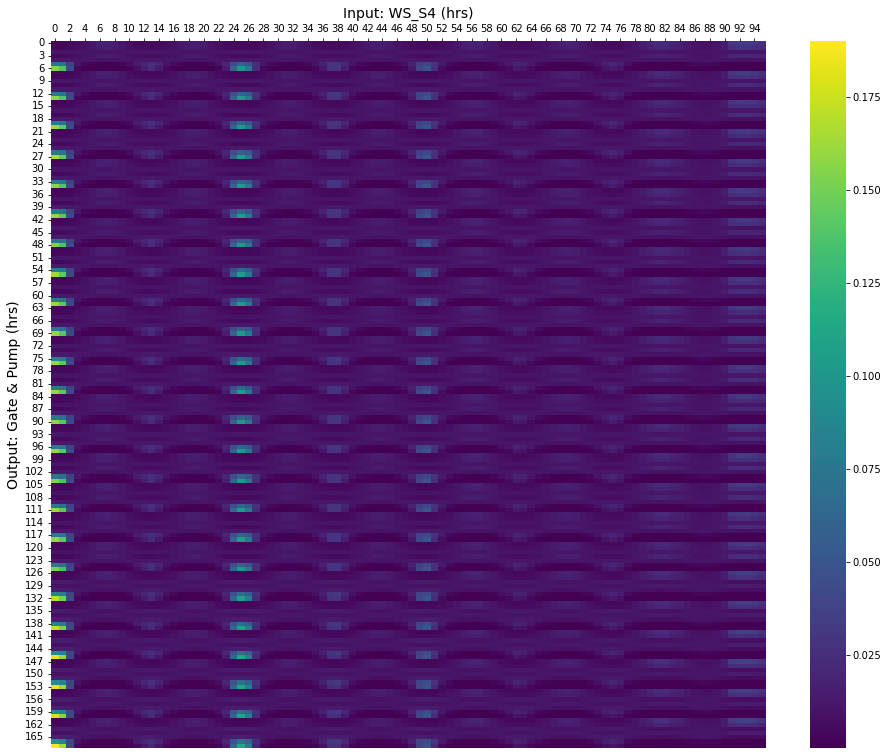

Attention for GATE_S25A input:


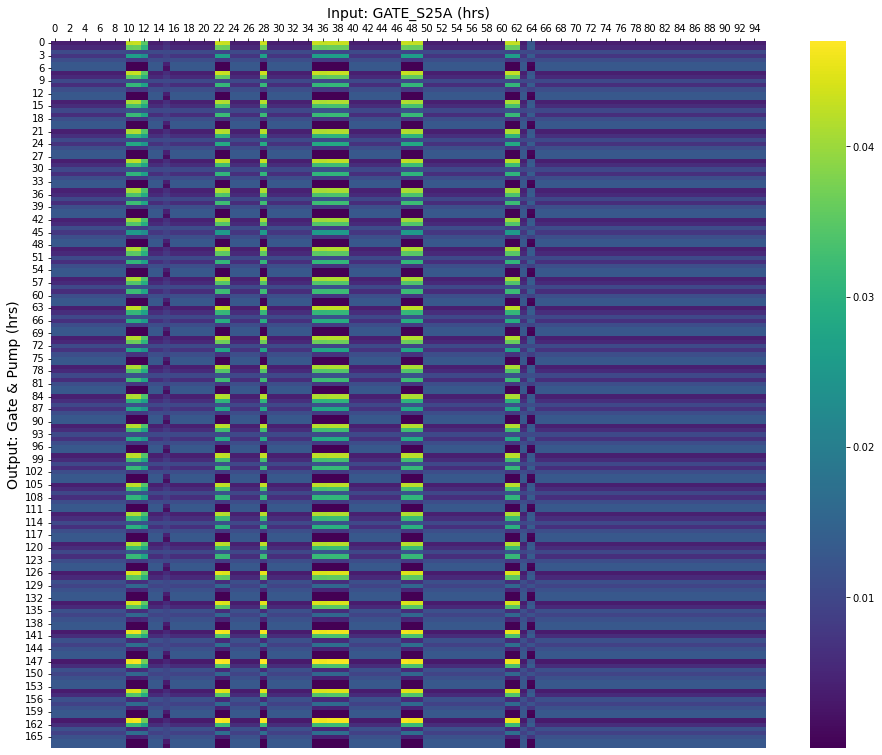

Attention for GATE_S25B input:


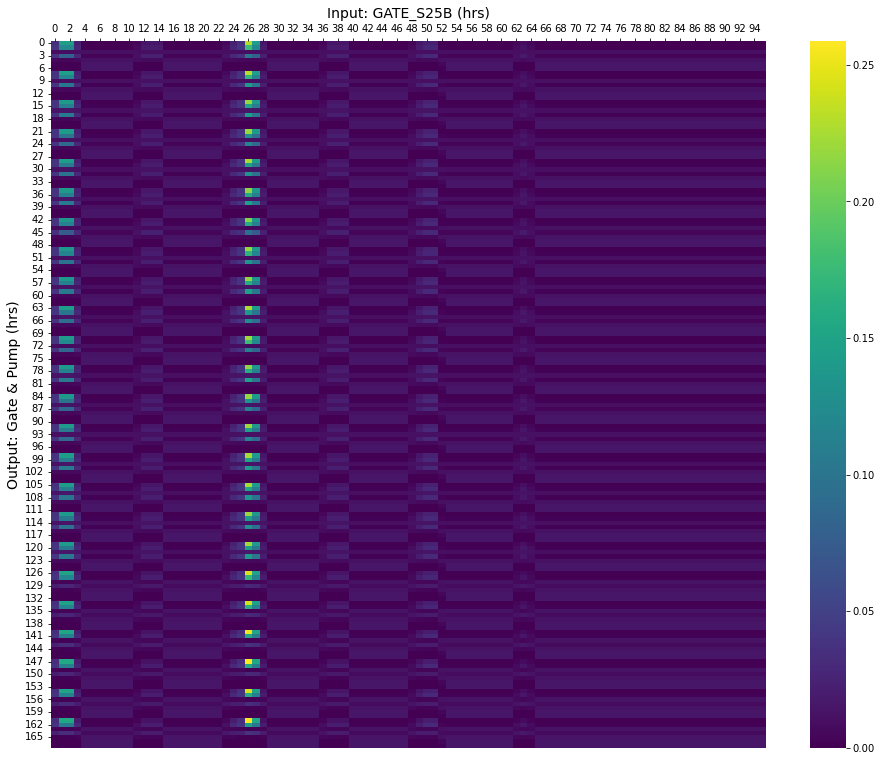

Attention for GATE_S25B2 input:


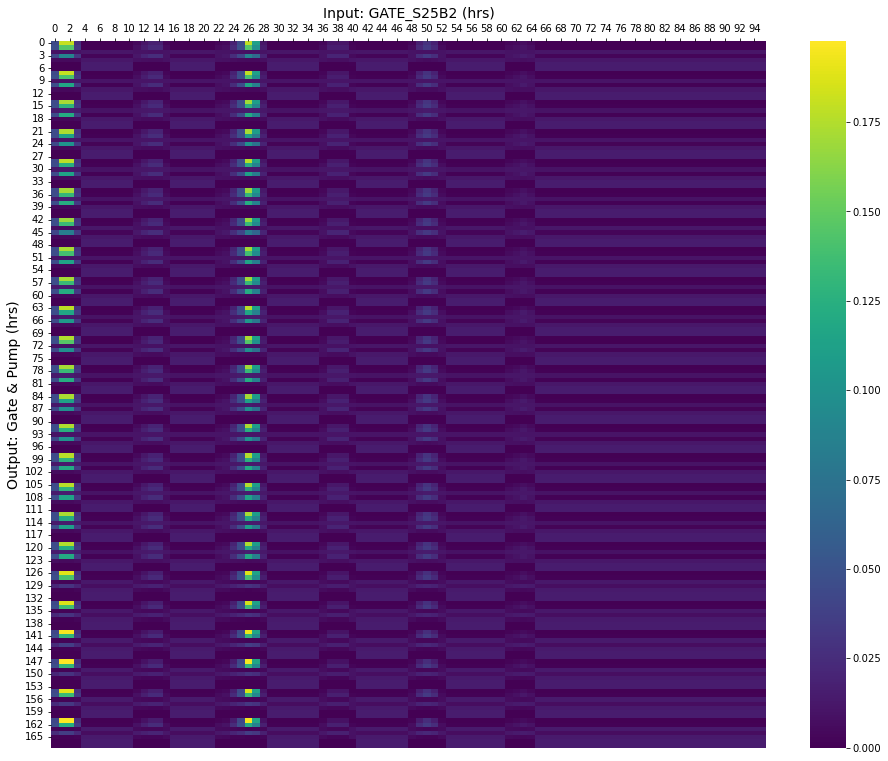

Attention for GATE_S26_1 input:


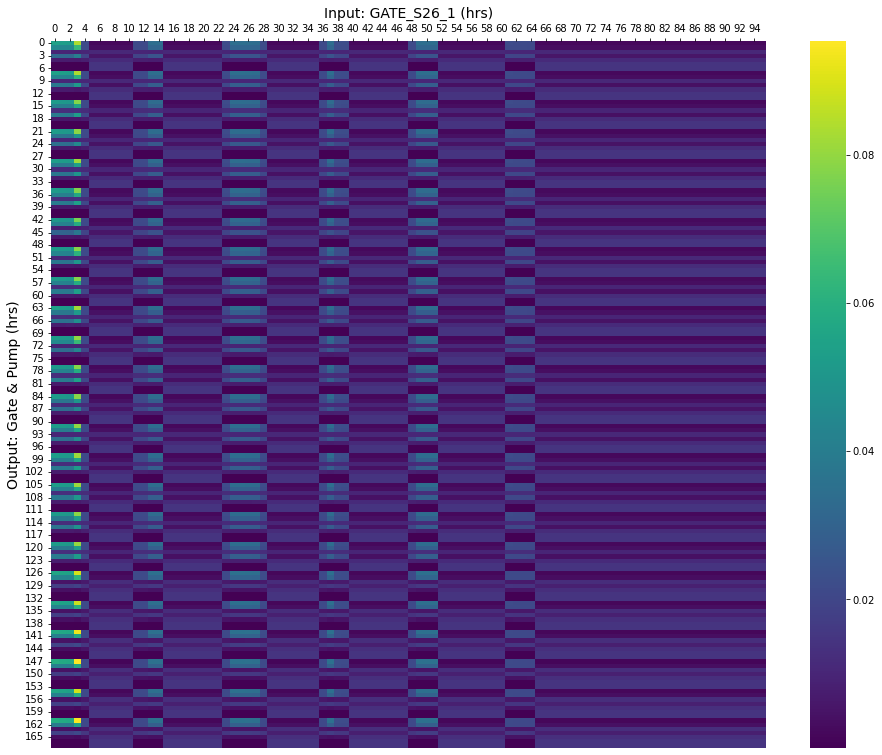

Attention for GATE_S26_2 input:


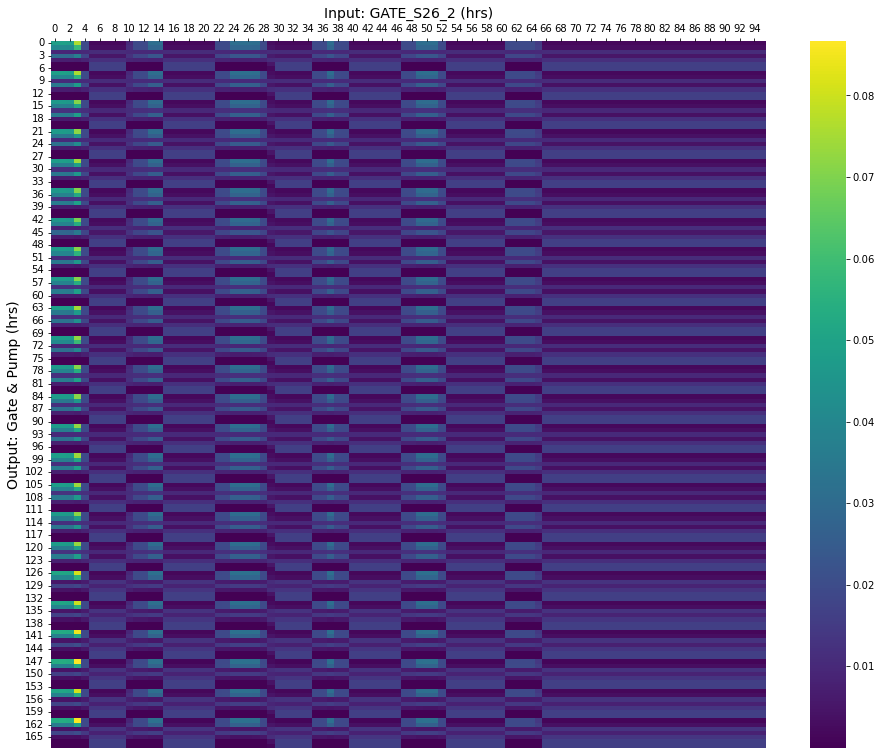

Attention for PUMP_S25B input:


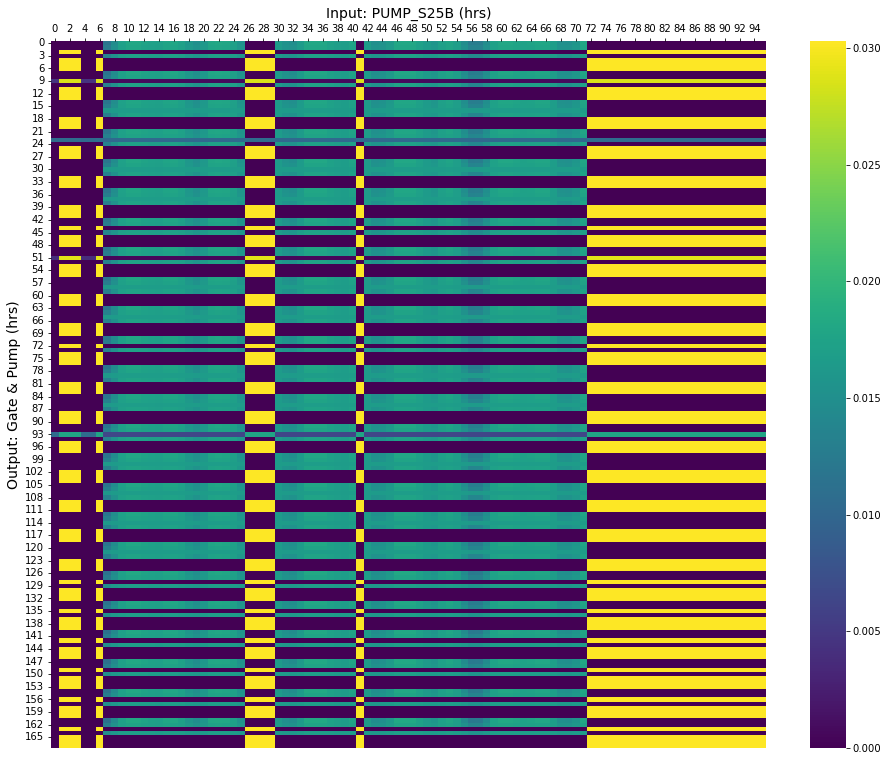

Attention for PUMP_S26 input:


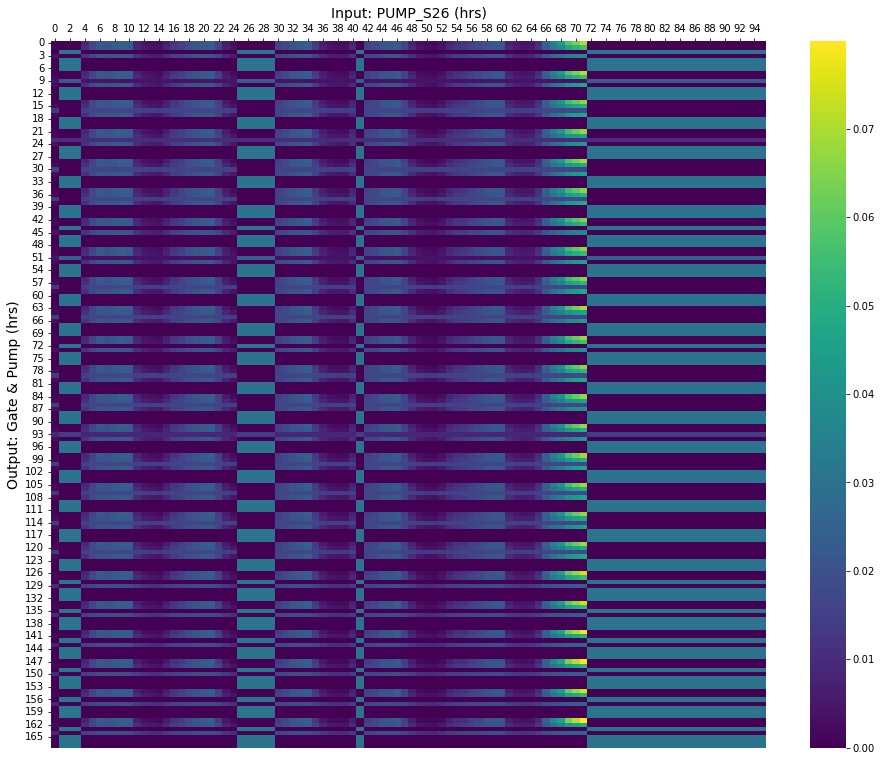

Attention for HWS_S25A input:


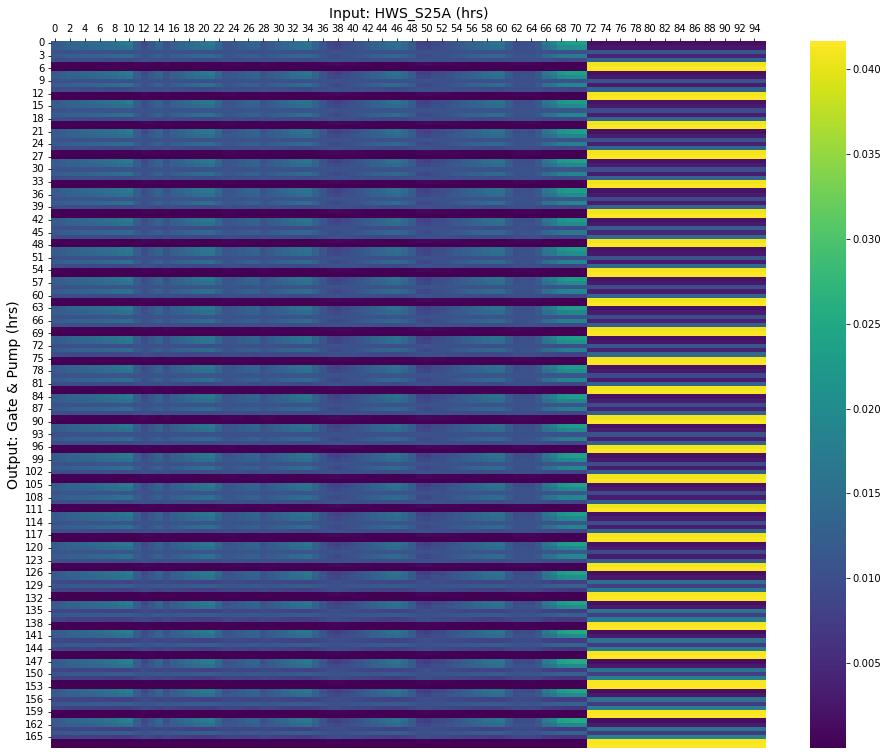

Attention for HWS_S25B input:


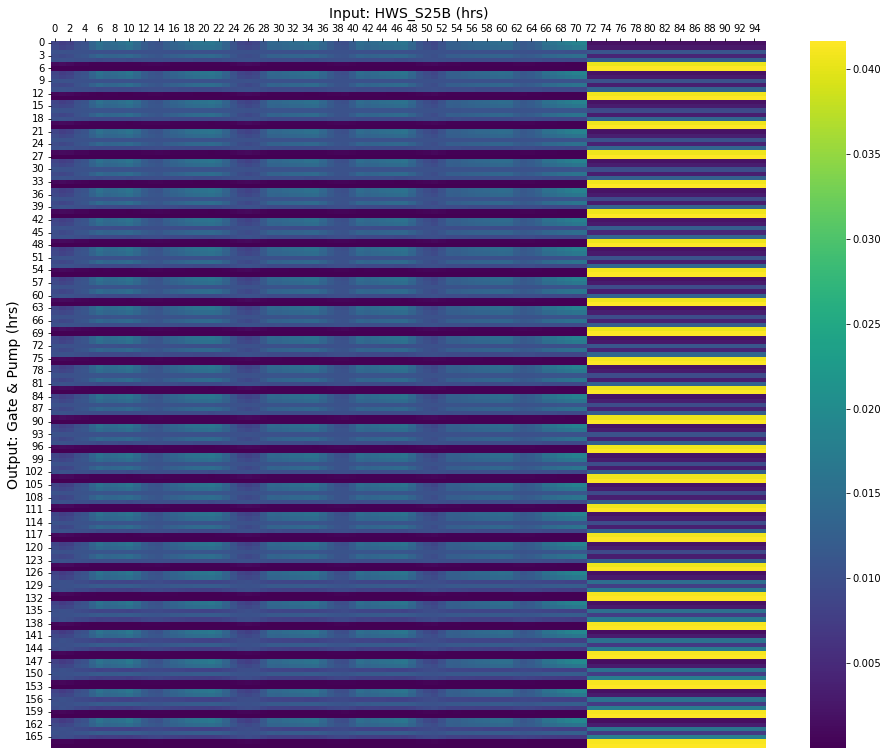

Attention for HWS_S26 input:


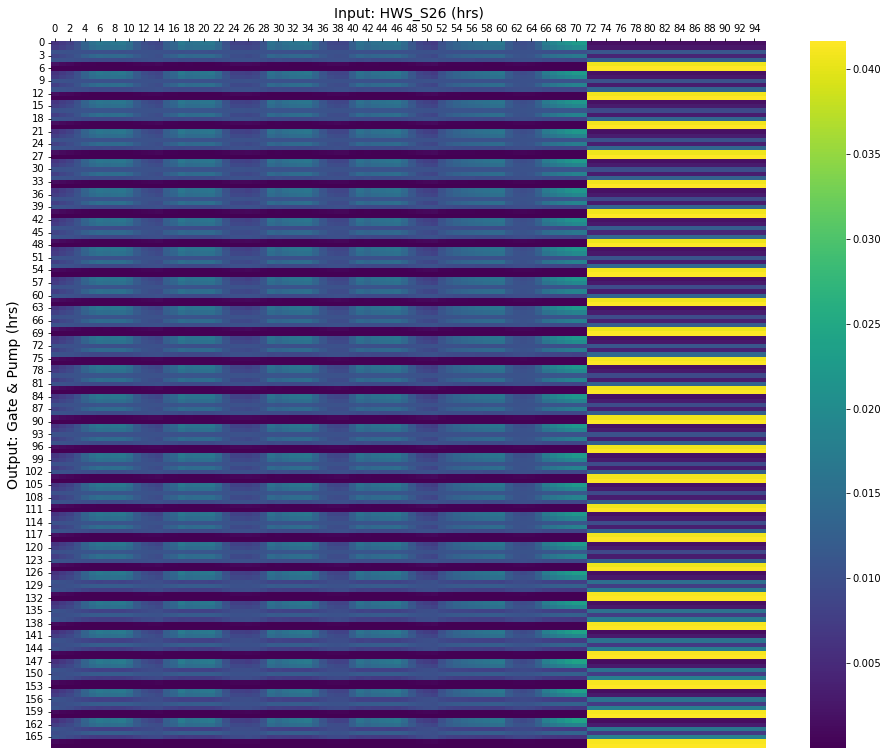

Attention for WS_S1 input:


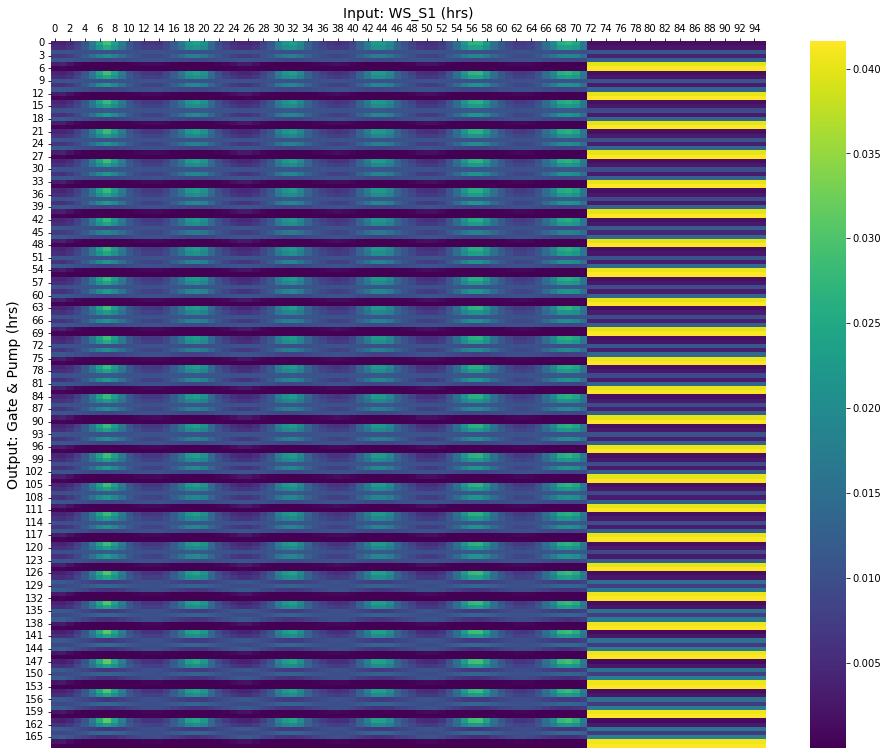

Attention for TWS_S25A input:


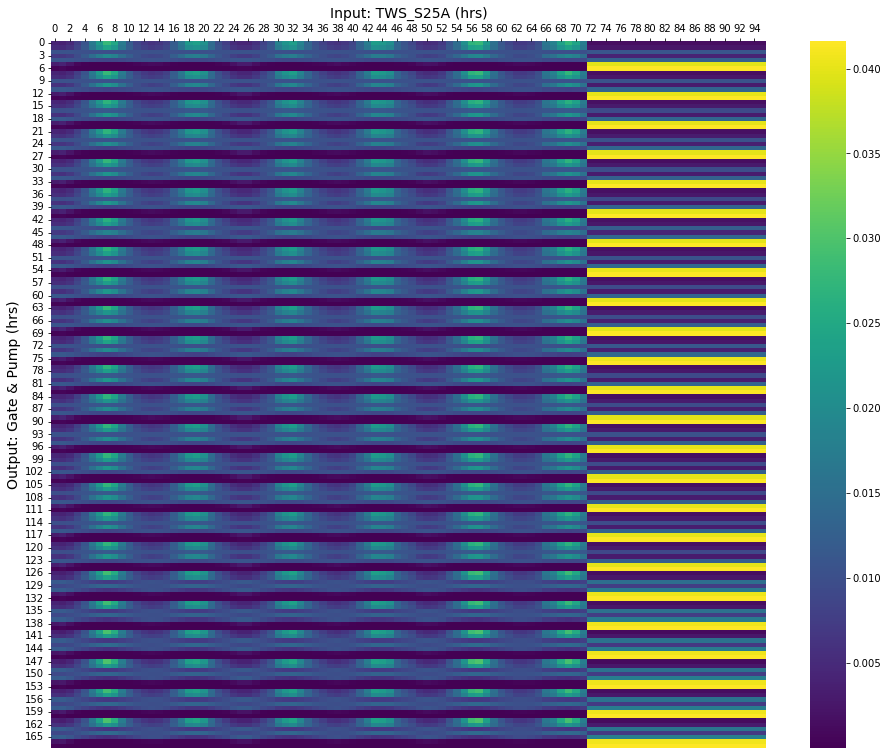

Attention for TWS_S25B input:


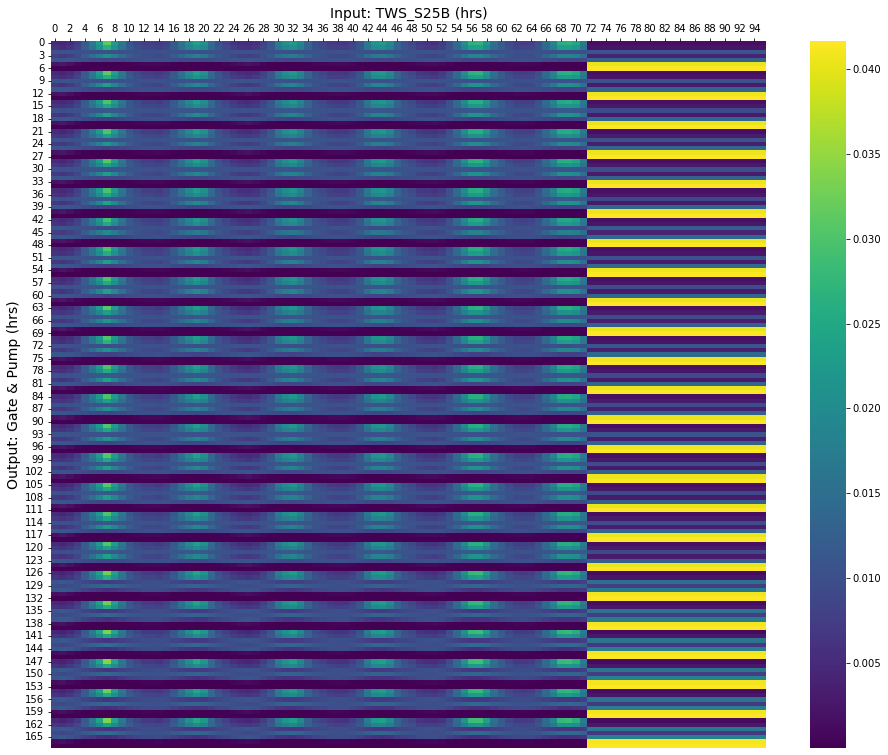

Attention for TWS_S26 input:


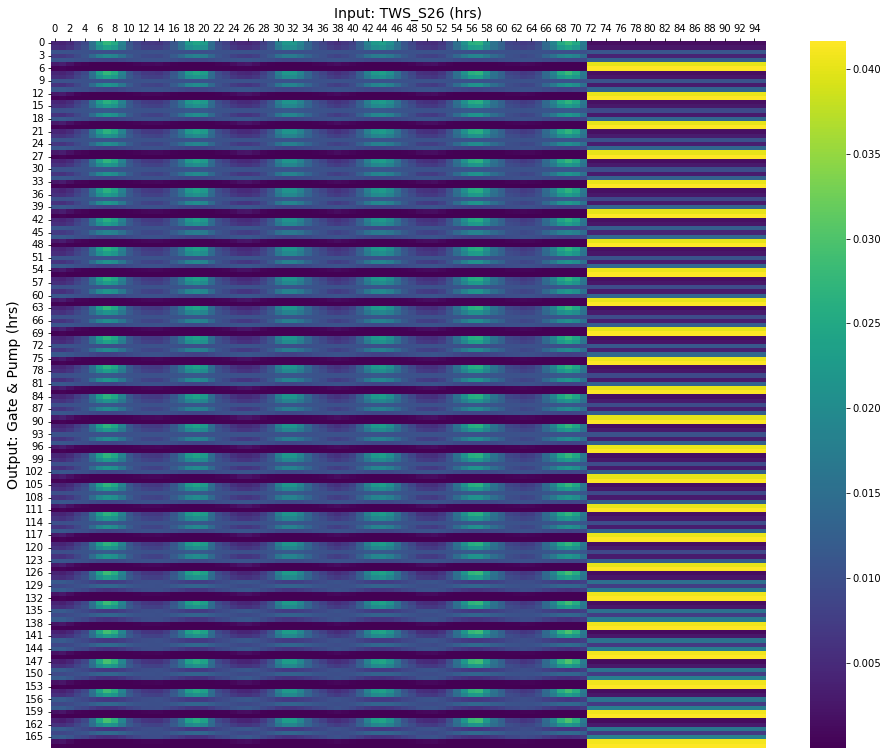

In [24]:
VARS = ['MEAN_RAIN', 'WS_S4',
        'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
        'PUMP_S25B', 'PUMP_S26',
        #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
        'HWS_S25A', 'HWS_S25B', 'HWS_S26',
        'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

FONTSIZE = 14

for i in range(len(VARS)):
    print("Attention for {} input:".format(VARS[i]))
    atte_opt, atte_score = layers.Attention()([gate_pump_pred_demo, original_input_demo[:, i:i+1]], 
                                              return_attention_scores=True
                                             )
    plt.rcParams["figure.figsize"] = (16, 13)

    ax = sns.heatmap(atte_score, cmap="viridis")   # , cmap="crest"
    ax.xaxis.tick_top()
    plt.ylabel("Output: Gate & Pump (hrs)", fontsize=FONTSIZE)
#     plt.xlabel("Input: {} (hrs)".format(VARS[i]), fontsize=FONTSIZE)
    plt.title("Input: {} (hrs)".format(VARS[i]), fontsize=FONTSIZE)
    #plt.title("Attention Score: Output (24*4 hrs) vs Input {} (96 hrs)".format(VARS[i]), fontsize=FONTSIZE)
    plt.show()

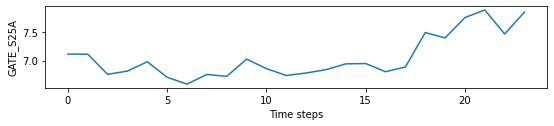

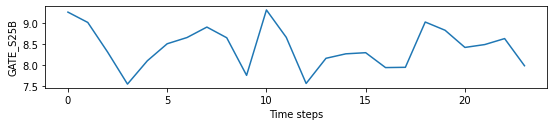

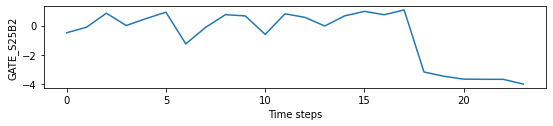

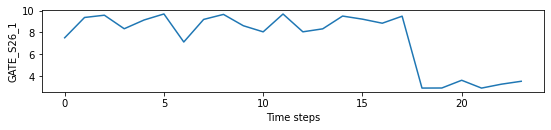

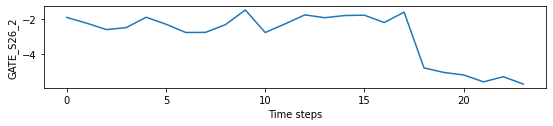

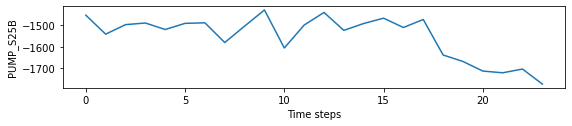

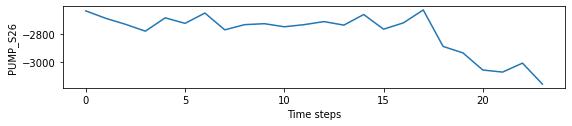

In [25]:
gate_pump = ['GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26']

for i in range(len(gate_pump)):
    plt.rcParams["figure.figsize"] = (9, 1.5)
    plt.plot(gate_pump_pred_inv[demo, :, i])
    plt.xlabel('Time steps')
    plt.ylabel('{}'.format(gate_pump[i]))
    plt.show()
#     plt.close()

(19268, 1536)
(19268, 1536)
(19268, 96, 16)


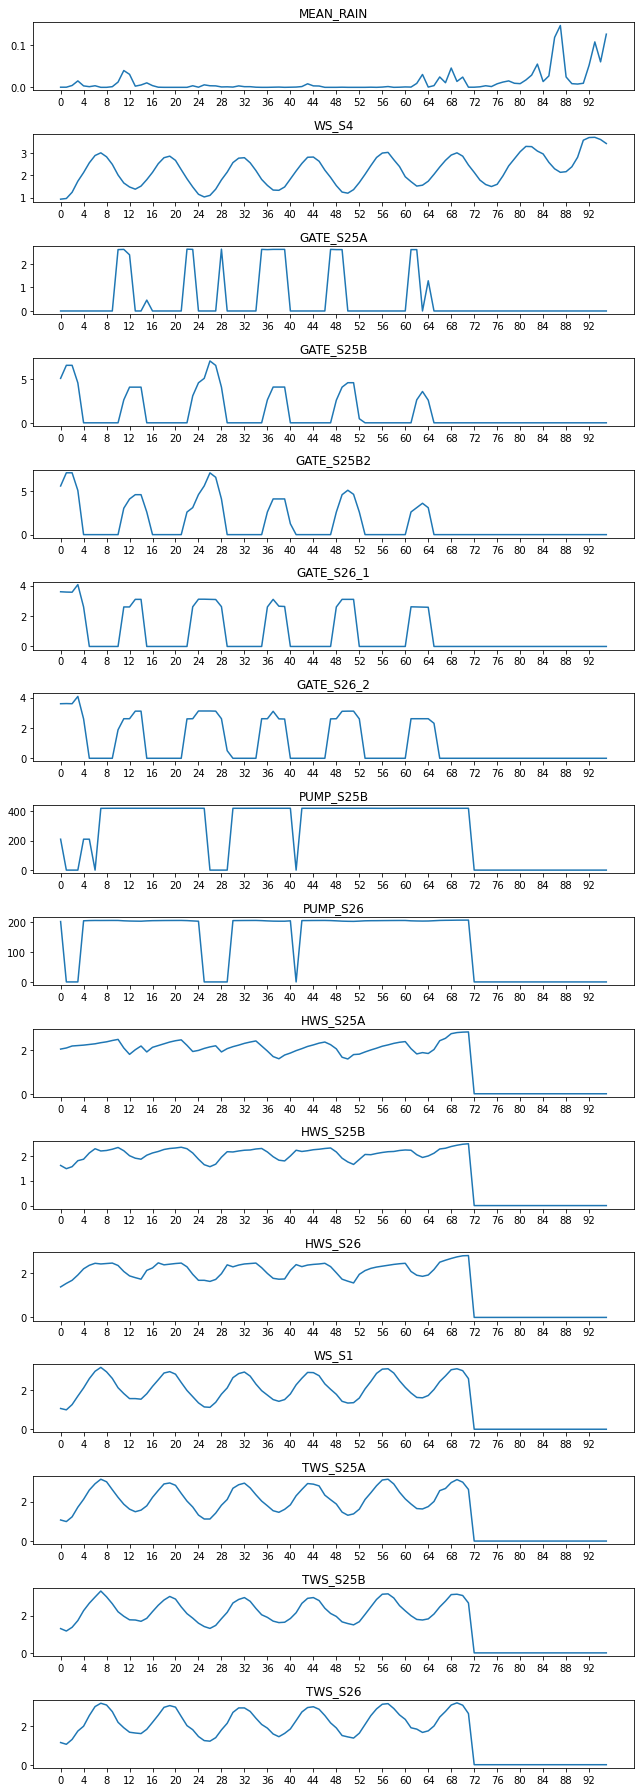

In [28]:
INPUTS = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
          'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']


test_X_mask_reshape = test_X_mask.reshape((-1, 96*16))
print(test_X_mask_reshape.shape)

test_X_mask_inv = scaler.inverse_transform(test_X_mask_reshape)
print(test_X_mask_inv.shape)

test_X_mask_inv = test_X_mask_inv.reshape((-1, 96, 16))
print(test_X_mask_inv.shape)


plt.rcParams["figure.figsize"] = (9, 25)
fig = plt.figure(tight_layout=True)
gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)


for i in range(len(INPUTS)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(test_X_mask_inv[demo, :, i], linewidth=1.5)
    ax.set_title('{}'.format(INPUTS[i]), fontsize=12)
    plt.xticks(np.arange(0, 96, 4))
    
# plt.savefig('INPUTS.png', dpi=300, bbox_inches='tight')
plt.show()

### Integrated_gradients

In [30]:
from explainability import integrated_gradients, colorline

In [44]:
saved_model_layers = saved_model.layers[:2]

input_tensor = [layer.input for layer in saved_model_layers]

output_tensor = saved_model_layers[-1].output

gate_predictor = Model(inputs=input_tensor, outputs=output_tensor)
gate_predictor.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 16)]     0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 96, 16)       0           input_4[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_3 (MultiHe (None, 96, 16)       8592        masking_3[0][0]                  
                                                                 masking_3[0][0]                  
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 96, 16)       0           multi_head_attention_3[0][0

In [45]:
input_data = test_X_mask[demo:demo+1]
baseline_data = np.zeros((1, 96, 16), dtype=np.float32)

# Compute integrated gradients
attributions = integrated_gradients(gate_predictor, input_data, baseline_data)


feature_matrix = []
attribute_matrix = []

for feature, attribution in zip(input_data[0], attributions[0]):
    #print(feature.shape, input_data[0].shape)
    #print(f"Feature: {feature}, Attribution: {attribution}")
    feature_matrix.append(feature)
    attribute_matrix.append(attribution.numpy()) 

ValueError: Layer model_3 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor: shape=(1, 96, 16), dtype=float32, numpy=
array([[[6.17283920e-04, 4.19921875e-01, 0.00000000e+00, ...,
         4.30232525e-01, 4.81132030e-01, 4.40740764e-01],
        [6.17283920e-04, 4.25781250e-01, 0.00000000e+00, ...,
         4.14728642e-01, 4.56603736e-01, 4.24074084e-01],
        [8.64197500e-03, 4.80468750e-01, 0.00000000e+00, ...,
         4.61240292e-01, 4.94339585e-01, 4.70370382e-01],
        ...,
        [2.13580236e-01, 9.64843750e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.19753085e-01, 9.45312500e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.50000000e-01, 9.10156250e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]], dtype=float32)>]

In [ ]:
feature_matrix_np = np.array(feature_matrix)
attribute_matrix_np = np.array(attribute_matrix)

In [ ]:
# paper: https://arxiv.org/pdf/1703.01365.pdf

"""
The Integrated Gradients method computes the integral of gradients along a straight path 
between a baseline input and the actual input to attribute importance to each feature. 

The key idea behind is to assign attribution or importance scores to the input features of a deep neural network, 
indicating their contribution to the network's output predictions.
"""

# Create a heatmap
plt.rcParams["figure.figsize"] = (19, 6)
sns.heatmap(attribute_matrix_np.T, cmap='viridis')

# Add labels and title
plt.ylabel("Features")
plt.xlabel("Time steps")
plt.title("Importance scores to input features")

# Display the plot
plt.show()

In [ ]:
labels = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
          'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

df_cm = pd.DataFrame(attribute_matrix_np, columns = labels)
plt.rcParams["figure.figsize"] = (19, 6)
sns.heatmap(df_cm.T, annot=False, cmap='viridis')

In [ ]:
labels = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
          'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

for i in range(len(labels)):
    plt.figure(figsize = (9, 1))
    plt.plot(df_cm[labels[i]])
    plt.ylabel('{}'.format(labels[i]))
    plt.show()
    plt.close()